# Full circuit for 1+1d SU(2) Trotter simulation using the LSH formulation with $L=4$, $\Lambda=2$

Using a qutrit to represent the bosonic dof at r=2.

The possible quantum numbers at each site are:
- r=0:
  - (ni, no) = (0, 0), (0, 1), (1, 1)
  - nl = 0
- r=1:
  - (ni, no) = all combinations
  - nl = 0, 1
- r=2: all combinations
- r=3: (ni, no, nl) = (0, 0, 1), (0, 1, 0), (1, 0, 1), (1, 1, 1)

Considering first-order Trotter for the moment.

## On the non-use of relative-phase Toffoli

- Double-controlled incrementer in the hopping terms seems like a prime application of CNOT cost reduction by the use of relative-phase Toffolis.
- However, there is the Hadamard acting on one of the qubits, which require that the relative phases factor out (acts identically) on this qubit.
- As an example, if the qubit with the Hadamard is taken to be the most significant, the relative-phase Toffoli must have a form $\mathrm{diag}(z_0, z_1, z_2, z_3, z_0, z_1, \begin{pmatrix} & z_2 \\ z_3 & \end{pmatrix})$, i.e., the full Toffoli multiplied by $\mathrm{diag}(z_0, z_1, z_2, z_3, z_0, z_1, z_2, z_3)$ from the left.
- A parity network can never create a Toffoli-like structure alone (there will be at least two pairs of basis exchange). Typical construction of a Toffoli is by a parity network sandwitched by two Hadamards. (Here we have not ruled out possibilities of other constructions, but I suspect any apparently different one turns out to be equivalent to H-parity-H)
- The "X" part of relative-phase Toffoli under such a construction would be either an X or a Y. If it is a Y, the parity network must result in a Y at the same location because $HYH \propto Y$. This conflicts with the requirement of factoring out a qubit because 

## Qubit placement

- All double-control gates appear in inverting pairs. Relative-phase Toffolis suffice to realize the desired effect.
  - Relative-phase Toffolis are CNOT-efficient only when the target qubit is in the middle in a linear topology.
- The interaction Hamiltonian contains high-weight diagonals which are the most efficient when certain qubits are at the edges.

Above considerations lead to the following qubit placement and routing:

1. o-l-i=i+l+o-o-l-i= ... -> CX[i(r)-i(r+1)] and CClambda[i(r+1), o(r+1), l(r+1)] of U_svd(1)
1. o-i-l-i-l-o-o-i-l- ... -> SWAP l(r) and i(r)
1. i-o-l-i-l-o-i-o-l- ... -> SWAP o(r) and i(r)
1. i-o=l=i-l-o-i-o=l= ... -> CClambda[i(r+1), o(r), l(r)] of U_svd(1)
1. i-o-l-i-o-l-i-o-l- ... -> SWAP o(r+1) and l(r+1)
1. i-o-l-o-i-l-i-o-l- ... -> SWAP i(r+1) and o(r+1)
1. i=o=l=o=i-l-i=o=l= ... -> diagonal term G(1)
1. i-o-l-i-o-l-i-o-l- ... -> SWAP i(r+1) and o(r+1)
1. i-o-l-i-l-o-i-o-l- ... -> SWAP o(r+1) and l(r+1)
1. i-o=l=i-l-o-i-o=l= ... -> CClambda[i(r+1), o(r), l(r)] of U_svd(1)
1. o-i-l-i-l-o-o-i-l- ... -> SWAP o(r) and i(r)
1. o-l-i-i-l-o-o-l-i- ... -> SWAP l(r) and i(r)
1. o+l+i-i-l-o=o+l+i- ... -> CX[o(r+1)-o(r+2)] and CClambda[i(r+2), o(r+2), l(r+2)] of U_svd(2)
1. ...


In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import sys
sys.path.append('/home/iiyama/src/qutrit-experiments')
sys.path.append('/home/iiyama/src/lsh-qudit')
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.quantum_info import Operator
from qiskit_ibm_runtime.fake_provider import FakeTorino
from lsh_qudit.validator import validate_circuit
from lsh_qudit.utils import QubitPlacement, physical_states, sort_qubits, draw_circuit, clean_array
from lsh_qudit.hamiltonian import (mass_term, electric_12_term, electric_3f_term, electric_3b_term,
                                   hopping_term, hi1_mat, hi2_mat)

## Model parameters

In [3]:
num_sites = 4
mass_mu = Parameter('$\mu$')
interaction_x = Parameter('x')

time_step = Parameter('$\Delta$t')
# Random not-so-small numbers for numerical validation
dt = 0.73
mu = 0.37
x = 0.87

custom_gates = ['rccx_cct', 'rccx_cct_dg', 'rccx_ctc', 'rccx_ctc_dg', 'cq', r'c$\lambda^{-}$', r'c$\lambda^{-}$_dg']

backend = FakeTorino()

## $H_M$

$$
\begin{align*}
H_{M}(r) &= H_{M}^{(1)}(r) + H_{M}^{(2)}(r)\,, \\
H_{M}^{(1)}(r) &= \frac{\mu}{2}(-)^{r+1}Z_{i(r)}\,,\\
H_{M}^{(2)}(r) &= \frac{\mu}{2}(-)^{r+1}Z_{o(r)}\,
\end{align*}
$$

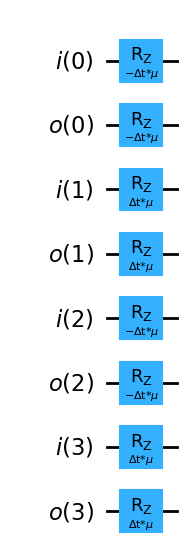

In [4]:
qp = QubitPlacement(sum(([('i', site), ('o', site)] for site in range(4)), []))
mass_circuit = QuantumCircuit(qp.num_qubits)
for site in range(4):
    circuit, init_p, _ = mass_term(site, time_step, mass_mu)
    mass_circuit.compose(circuit, qubits=[qp[lab] for lab in init_p.qubit_labels], inplace=True)
draw_circuit(mass_circuit, qp, reorder=False)

In [5]:
assigned = sort_qubits(mass_circuit, qp).assign_parameters({mass_mu: mu, time_step: dt})
op = np.zeros((2,) * (2 * num_sites))
pauliz = np.array([1., -1.])
for site in range(4):
    for io in range(2):
        dim = 2 * (4 - site) - io - 1
        extra_dims = list(range(dim)) + list(range(dim + 1, 8))
        op += np.expand_dims(pauliz * (-1 + 2 * (site % 2)), extra_dims)
op *= mu / 2. * dt
hmat = np.diagflat(op)
validate_circuit(assigned, hmat, diagonal=True)

True

## $H_E$

$$
\begin{align}
H_{E}&=H_{E}^{(1)} + H_{E}^{(2)} + H_{E}^{(3)}
\\
H_{E}^{(1)} & = \frac{1}{2}n_{l}(r)\,,
\\
H_{E}^{(2)} & = \frac{1}{4}n_{l}(r)^{2}\,,
\\
H_{E}^{(3)} & = \frac{1}{2}\left[n_{l}(r)+\frac{3}{2}\right] n_{o}(r) \left(1-n_{i}(r)\right)\,.
\end{align}
$$

### $H_E^{(1)} + H_E^{(2)} = \frac{1}{2}n_{l}(r) + \frac{1}{4}n_{l}(r)^{2}$

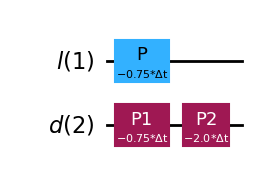

In [6]:
labels = [('l', 1), ('d', 2)]
qp = QubitPlacement(labels)
electric_12_circuit = QuantumCircuit(qp.num_qubits)
for site, bc in enumerate([{'left_flux': 0}, {'left_flux': (0, 1)}, {}]):
    circuit, init_p, _ = electric_12_term(site, time_step, **bc)
    electric_12_circuit.compose(circuit, qubits=[qp[lab] for lab in init_p.qubit_labels], inplace=True)
draw_circuit(electric_12_circuit, qp, reorder=False, fold=100)

In [7]:
assigned = sort_qubits(electric_12_circuit, qp).assign_parameters({time_step: dt})
op = np.zeros((3, 2))
op[:, 1] += 0.75
op[:] += np.array([0., 0.75, 2.])[:, None]
op *= dt
hmat = np.diagflat(op)
validate_circuit(assigned, hmat, qutrits=(1,))

True

### $H_E^{(3)} = \frac{1}{2}\left[n_{l}(r)+\frac{3}{2}\right] n_{o}(r) \left(1-n_{i}(r)\right)$

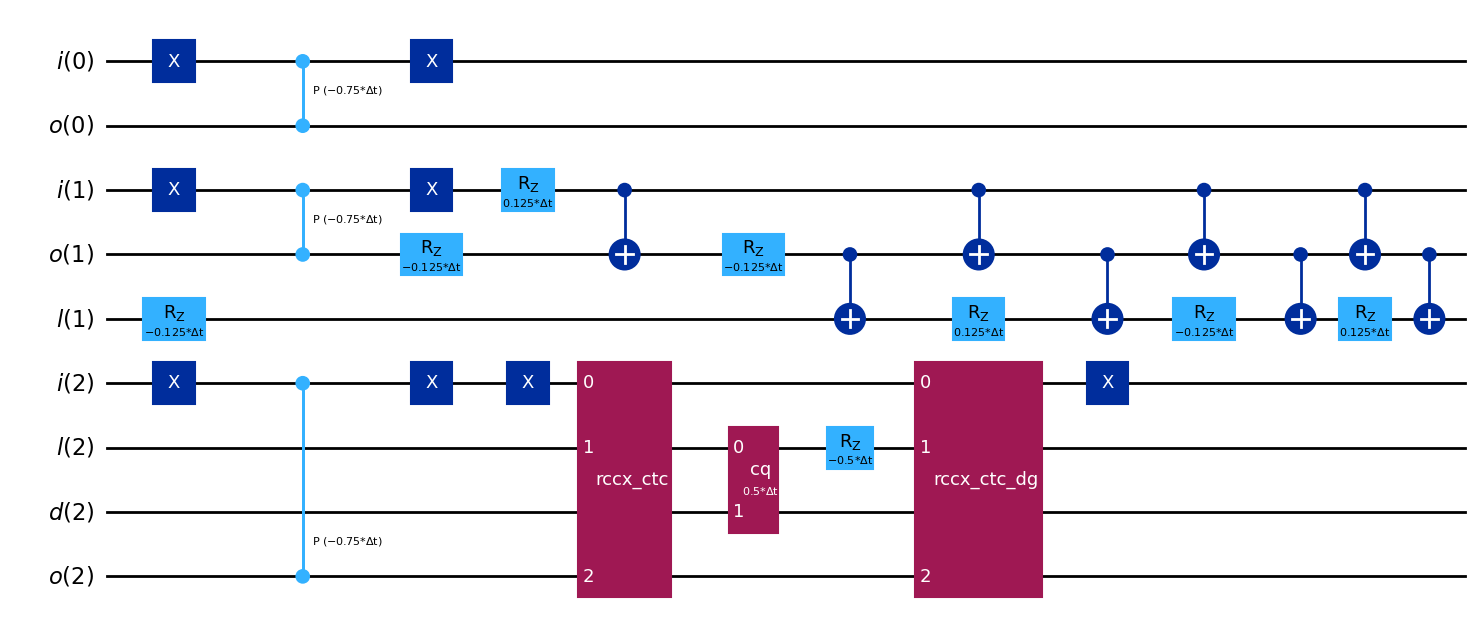

In [8]:
labels = [('i', 0), ('o', 0)]
labels += [('i', 1), ('o', 1), ('l', 1)]
labels += [('i', 2), ('l', 2), ('d', 2), ('o', 2)]
qp = QubitPlacement(labels)
electric_3_circuit = QuantumCircuit(qp.num_qubits)
for site, bc in enumerate([{'left_flux': 0}, {'left_flux': (0, 1)}, {}]):
    circuit, init_p, _ = electric_3f_term(site, time_step)
    electric_3_circuit.compose(circuit, qubits=[qp[lab] for lab in init_p.qubit_labels], inplace=True)
    circuit, init_p, _ = electric_3b_term(site, time_step, **bc)
    electric_3_circuit.compose(circuit, qubits=[qp[lab] for lab in init_p.qubit_labels], inplace=True)
draw_circuit(electric_3_circuit, qp, reorder=False, fold=100)

In [9]:
assigned = sort_qubits(electric_3_circuit.decompose(custom_gates), qp).assign_parameters({time_step: dt})
op = np.zeros((3, 2, 2, 2, 2, 2, 2, 2))
op[:, :, :, :, :, :, 1, 0] += 0.75
op[:, :, :, :, 1, 0] += 0.75
op[:, :, :, 1, 1, 0] += 0.5
op[:, 1, 0] += 0.75
op[1, 1, 0] += 0.5
op[2, 1, 0] += 1.
op *= dt
hmat = np.diagflat(op)
validate_circuit(assigned, hmat, qutrits=(8,), ancillae=(7,))

True

## $H_I$

### $H_I^{(1)}$

The general form of $H_I^{(1)}$ is

$$
\begin{split}
\frac{1}{x} H_I^{(1)}(r) = & H_I^{(1)+}(r) + H_I^{(1)-}(r) \\
= & \ket{0}\bra{1}_{i(r)} Z_{o(r)} \ket{1}\bra{0}_{i(r+1)} \left[ \lambda^+_{l(r)}
\left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r)} \right]^{1 - n_o(r)} \left[ \lambda^+_{l(r+1)}
\left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r+1)} \right]^{n_o(r+1)} \mathcal{D}\left(n_l(r), n_o(r), n_o(r+1)\right) \\
& + \ket{1}\bra{0}_{i(r)} Z_{o(r)} \ket{0}\bra{1}_{i(r+1)} \mathcal{D}\left(n_l(r), n_o(r), n_o(r+1)\right)
\left[ \left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r)} \lambda^-_{l(r)} \right]^{1 - n_o(r)}
\left[ \left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r+1)} \lambda^-_{l(r+1)} \right]^{n_o(r+1)}
\end{split}
$$

Note that the combinations of the allowed $n_i$ and $n_o$ values together with AGL dictates that a
non-annihilated state will have $n_l(r) = n_l(r+1)$.


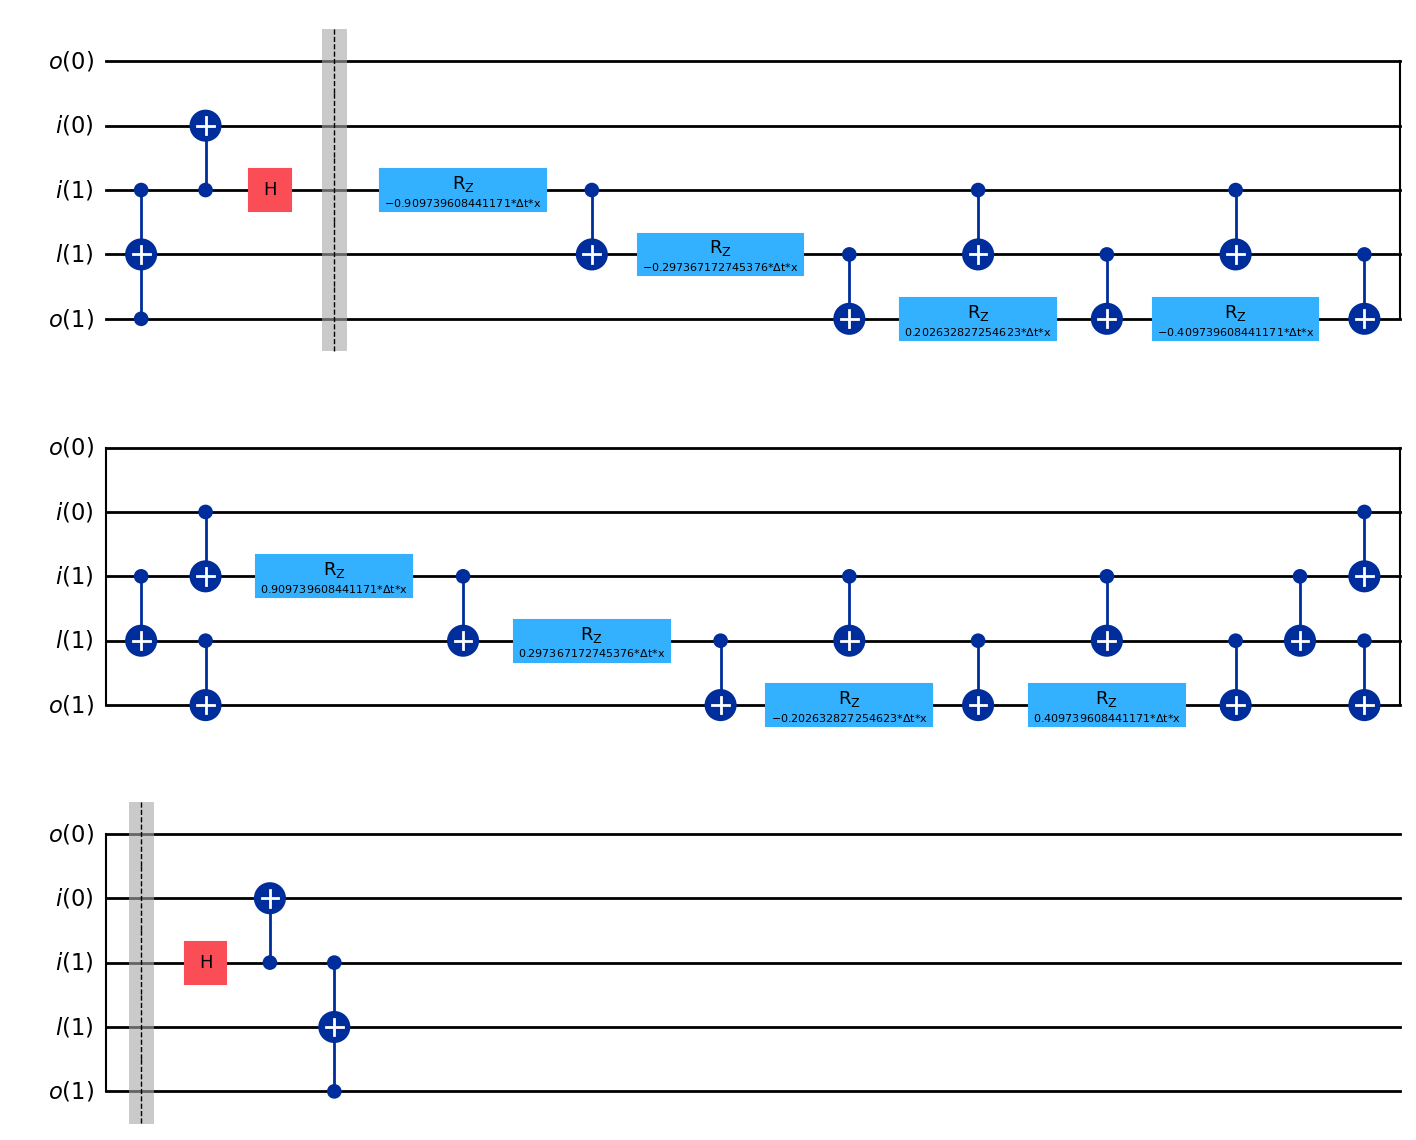

In [10]:
circuit, init_p, _ = hopping_term(1, 0, time_step, interaction_x, left_flux=0)
draw_circuit(circuit, init_p, reorder=False, fold=20)

In [11]:
assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
# Reverse the site ordering through embedding
embedded_qp = QubitPlacement([('l', 1), ('o', 1), ('i', 1), ('l', 0), ('o', 0), ('i', 0)])
embedded = QuantumCircuit(embedded_qp.num_qubits)
embedded.compose(assigned, qubits=[embedded_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi1_mat.reshape(4, 3, 4, 3, 4, 3, 4, 3)[:, :2, :, :2, :, :2, :, :2].reshape(64, 64) * x * dt
subspace = np.sum(physical_states(left_flux=0, num_sites=2, as_multi=True) << np.arange(6)[None, ::-1], axis=1)
validate_circuit(embedded, hmat, subspace=subspace)

True

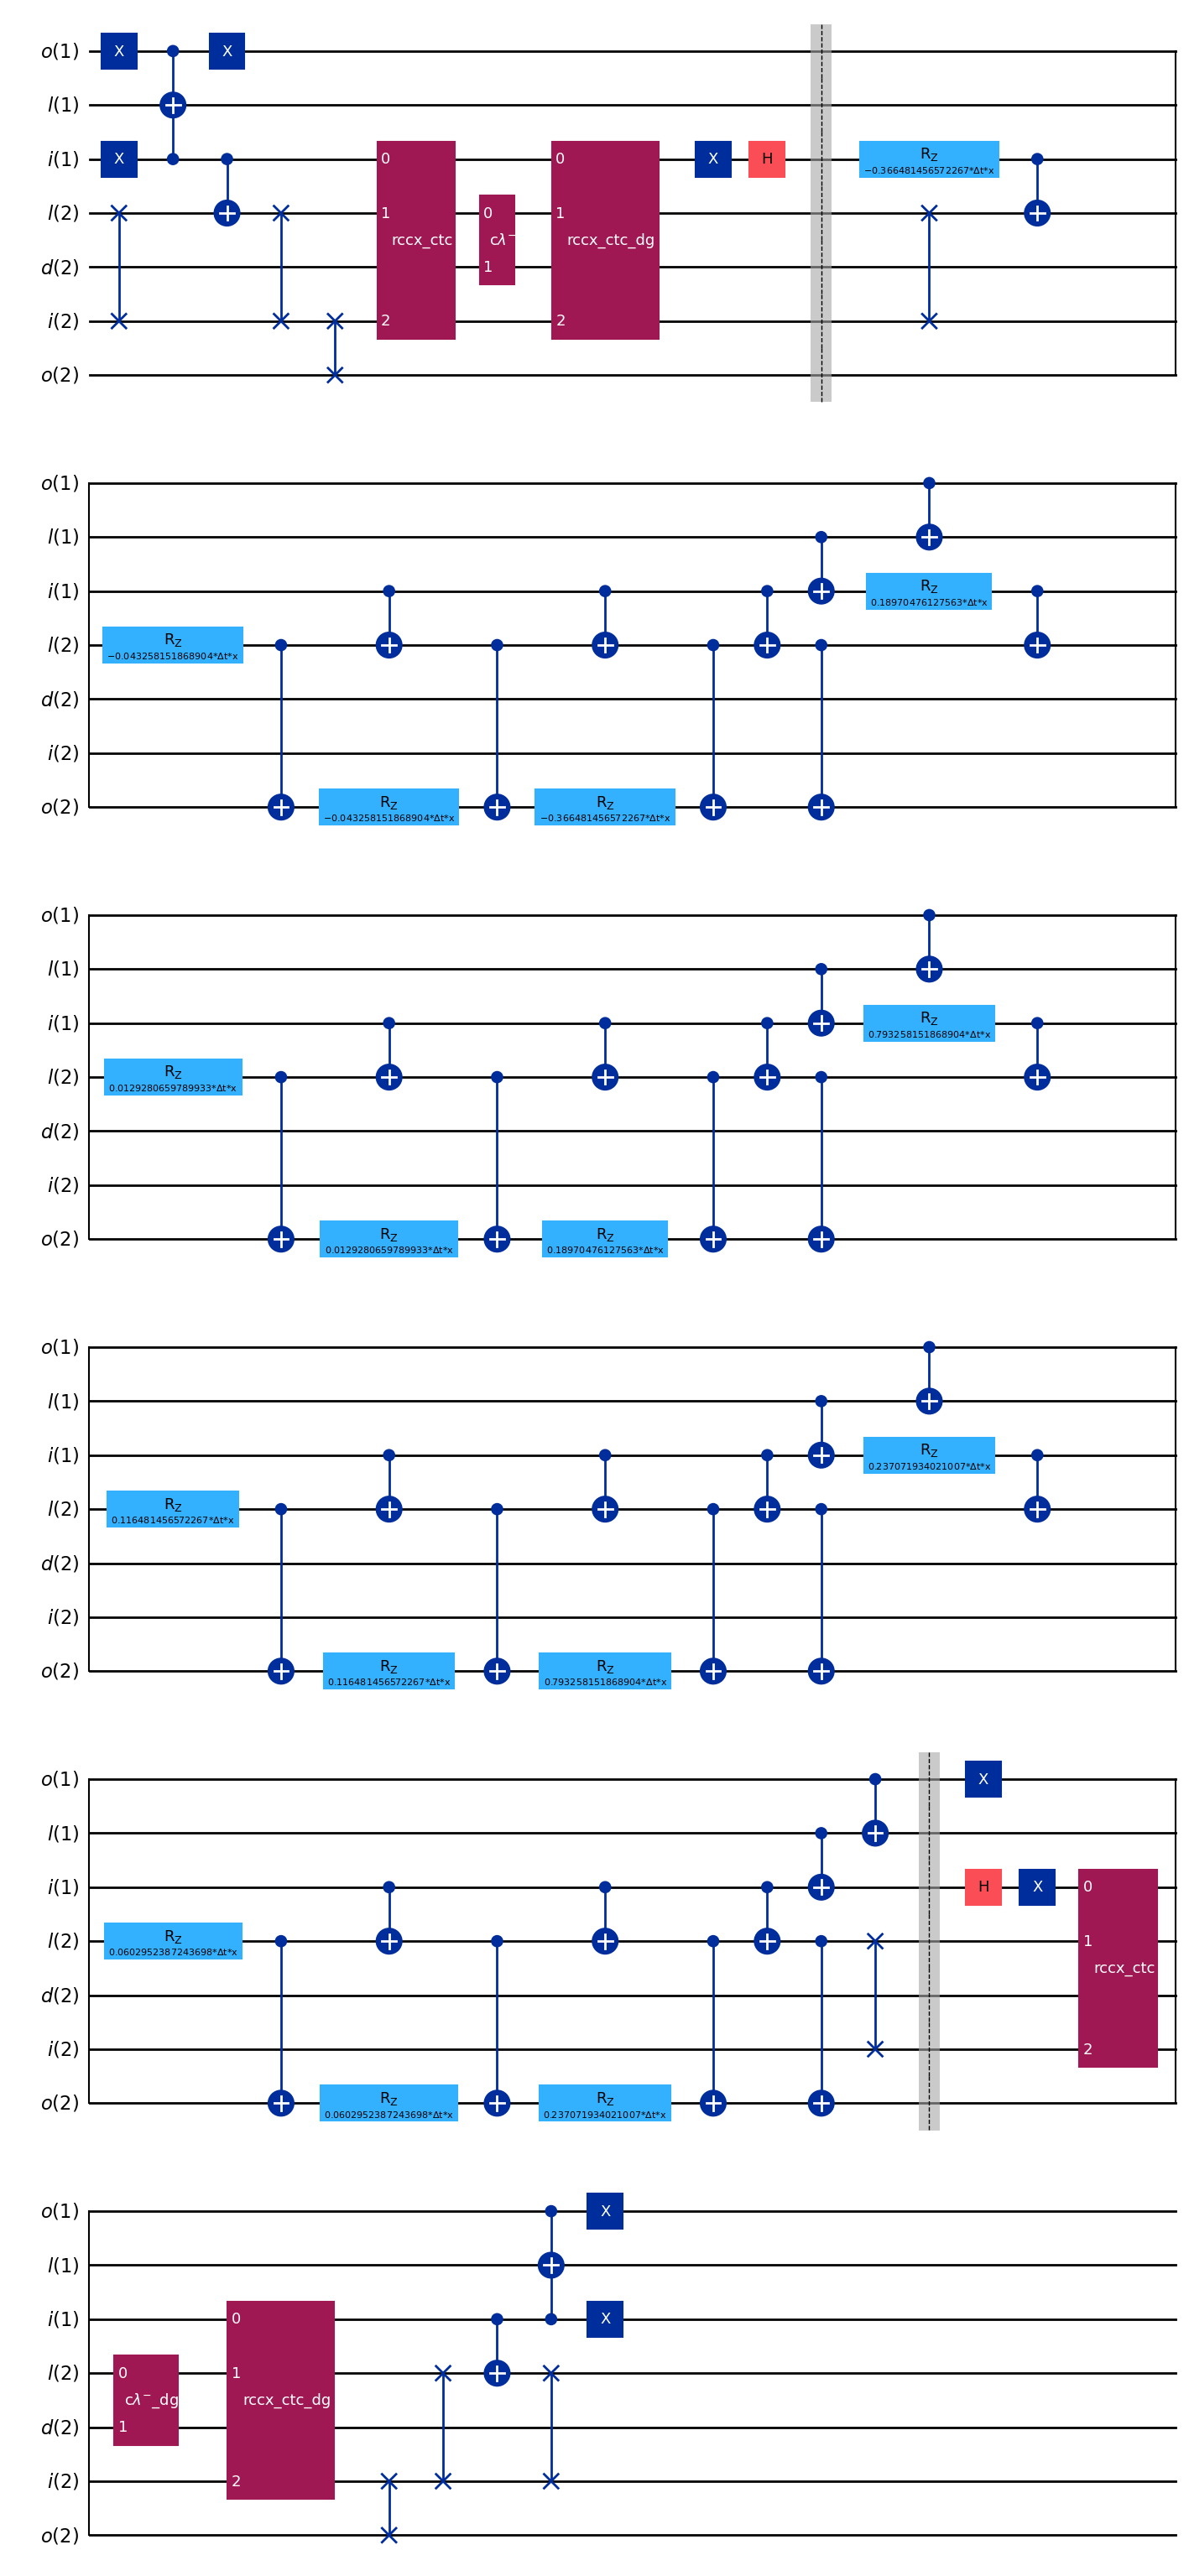

In [14]:
circuit, init_p, _ = hopping_term(1, 1, time_step, interaction_x, left_flux=(0, 1))
draw_circuit(circuit, init_p, reorder=False, fold=20)

In [15]:
assigned = circuit.decompose(custom_gates).assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('l', 2), ('d', 2), ('o', 2), ('i', 2), ('l', 1), ('o', 1), ('i', 1)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi1_mat.reshape(4, 3, 12, 4, 3, 12)[:, :2, :, :, :2, :].reshape(96, 96) * x * dt
subspace = np.sum(physical_states(left_flux=(0, 1), num_sites=2, as_multi=True) * np.cumprod([1, 3, 2, 2, 2, 2])[None, ::-1], axis=1)
validate_circuit(ordered, hmat, qutrits=(1,), ancillae=(0,), subspace=subspace)

True

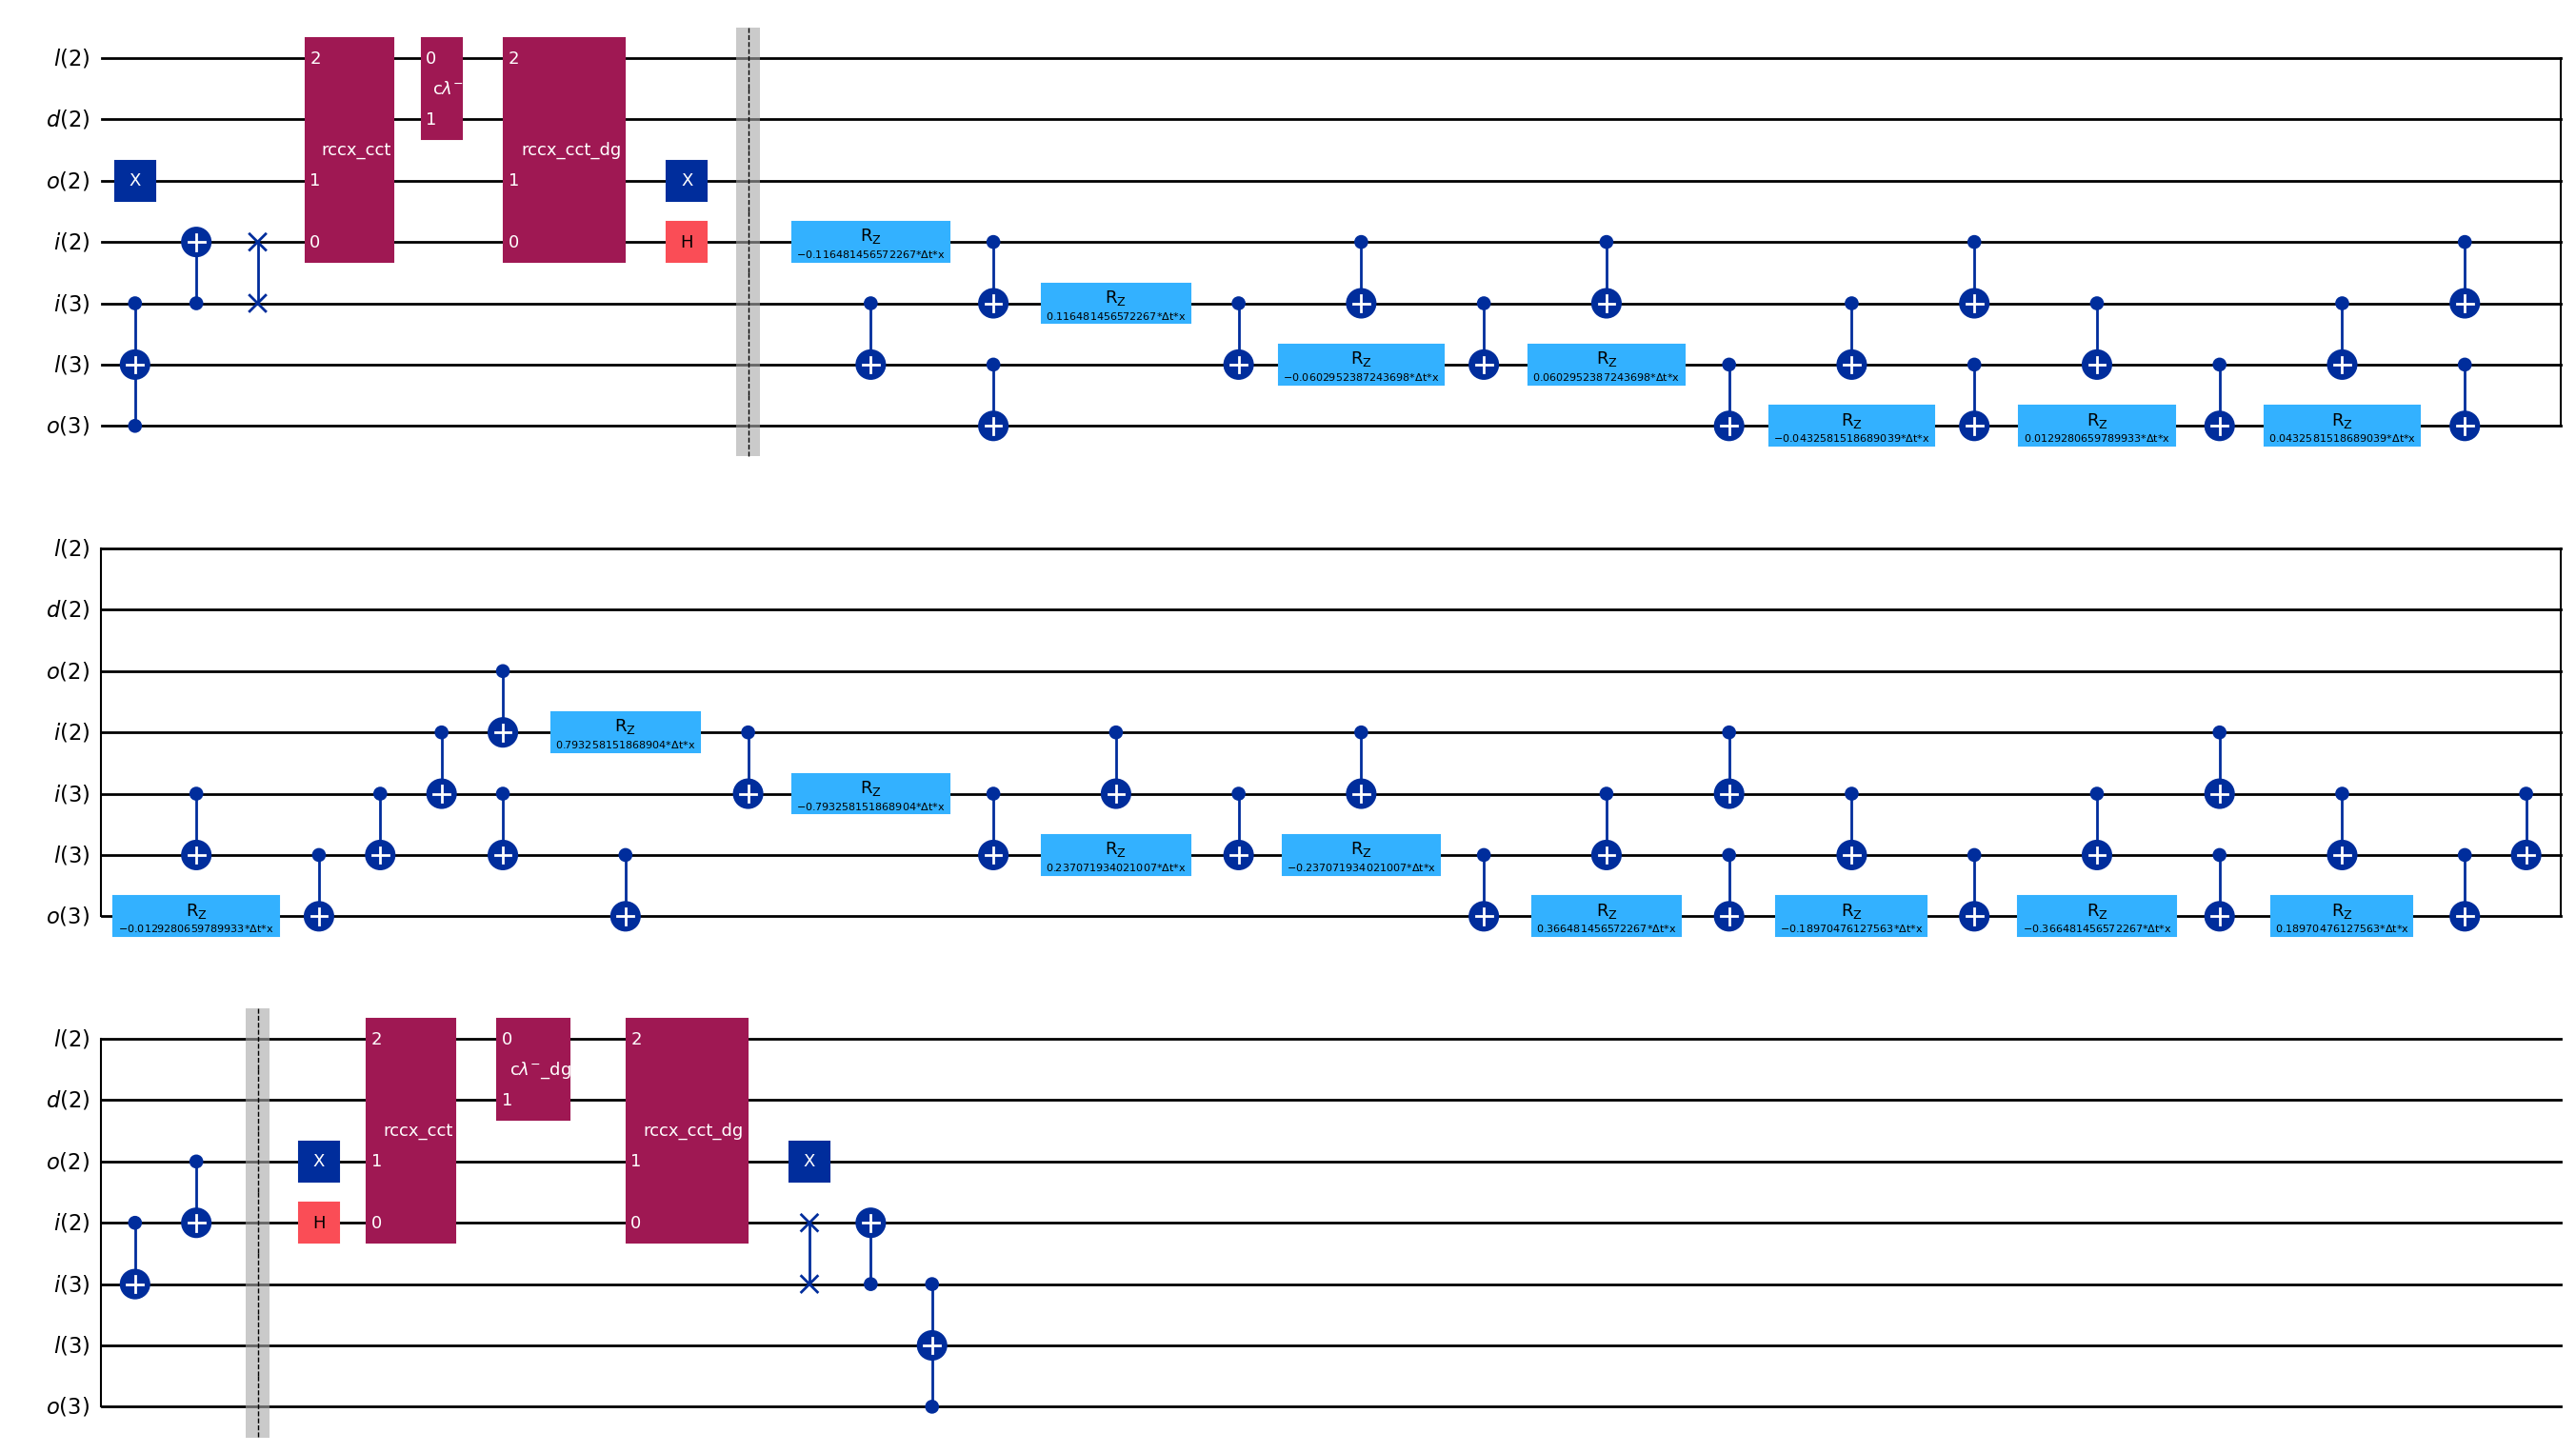

In [16]:
circuit, init_p, _ = hopping_term(1, 2, time_step, interaction_x, right_flux=(0, 1))
draw_circuit(circuit, init_p, reorder=False, fold=40)

In [17]:
assigned = circuit.decompose(custom_gates).assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('l', 3), ('o', 3), ('i', 3), ('l', 2), ('d', 2), ('o', 2), ('i', 2)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi1_mat.reshape(12, 4, 3, 12, 4, 3)[:, :, :2, :, :, :2].reshape(96, 96) * x * dt
subspace = np.sum(physical_states(right_flux=(0, 1), num_sites=2, as_multi=True) * np.cumprod([1, 2, 2, 2, 3, 2])[None, ::-1], axis=1)
validate_circuit(ordered, hmat, qutrits=(4,), ancillae=(3,), subspace=subspace)

True

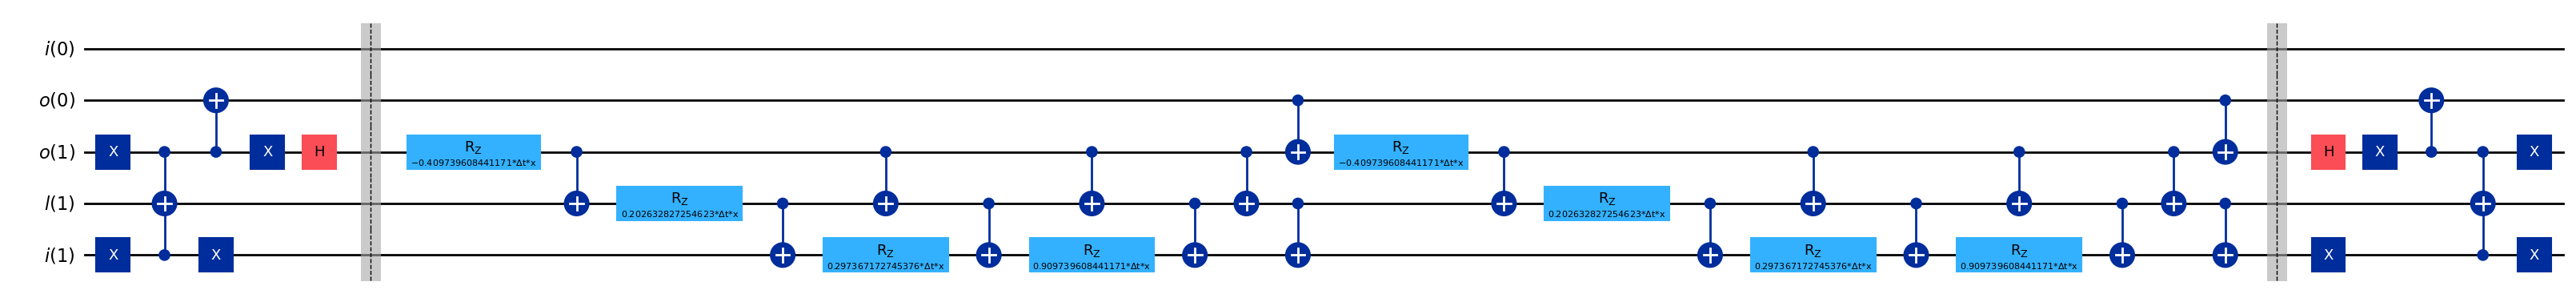

In [18]:
circuit, init_p, _ = hopping_term(2, 0, interaction_x, time_step, left_flux=0)
draw_circuit(circuit, init_p, reorder=False, fold=100)

In [19]:
assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
embedded_qp = QubitPlacement([('l', 1), ('o', 1), ('i', 1), ('l', 0), ('o', 0), ('i', 0)])
embedded = QuantumCircuit(embedded_qp.num_qubits)
embedded.compose(assigned, qubits=[embedded_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi2_mat.reshape(4, 3, 4, 3, 4, 3, 4, 3)[:, :2, :, :2, :, :2, :, :2].reshape(64, 64) * x * dt
subspace = np.sum(physical_states(left_flux=0, num_sites=2, as_multi=True) << np.arange(6)[None, ::-1], axis=1)
validate_circuit(embedded, hmat, subspace=subspace)

True

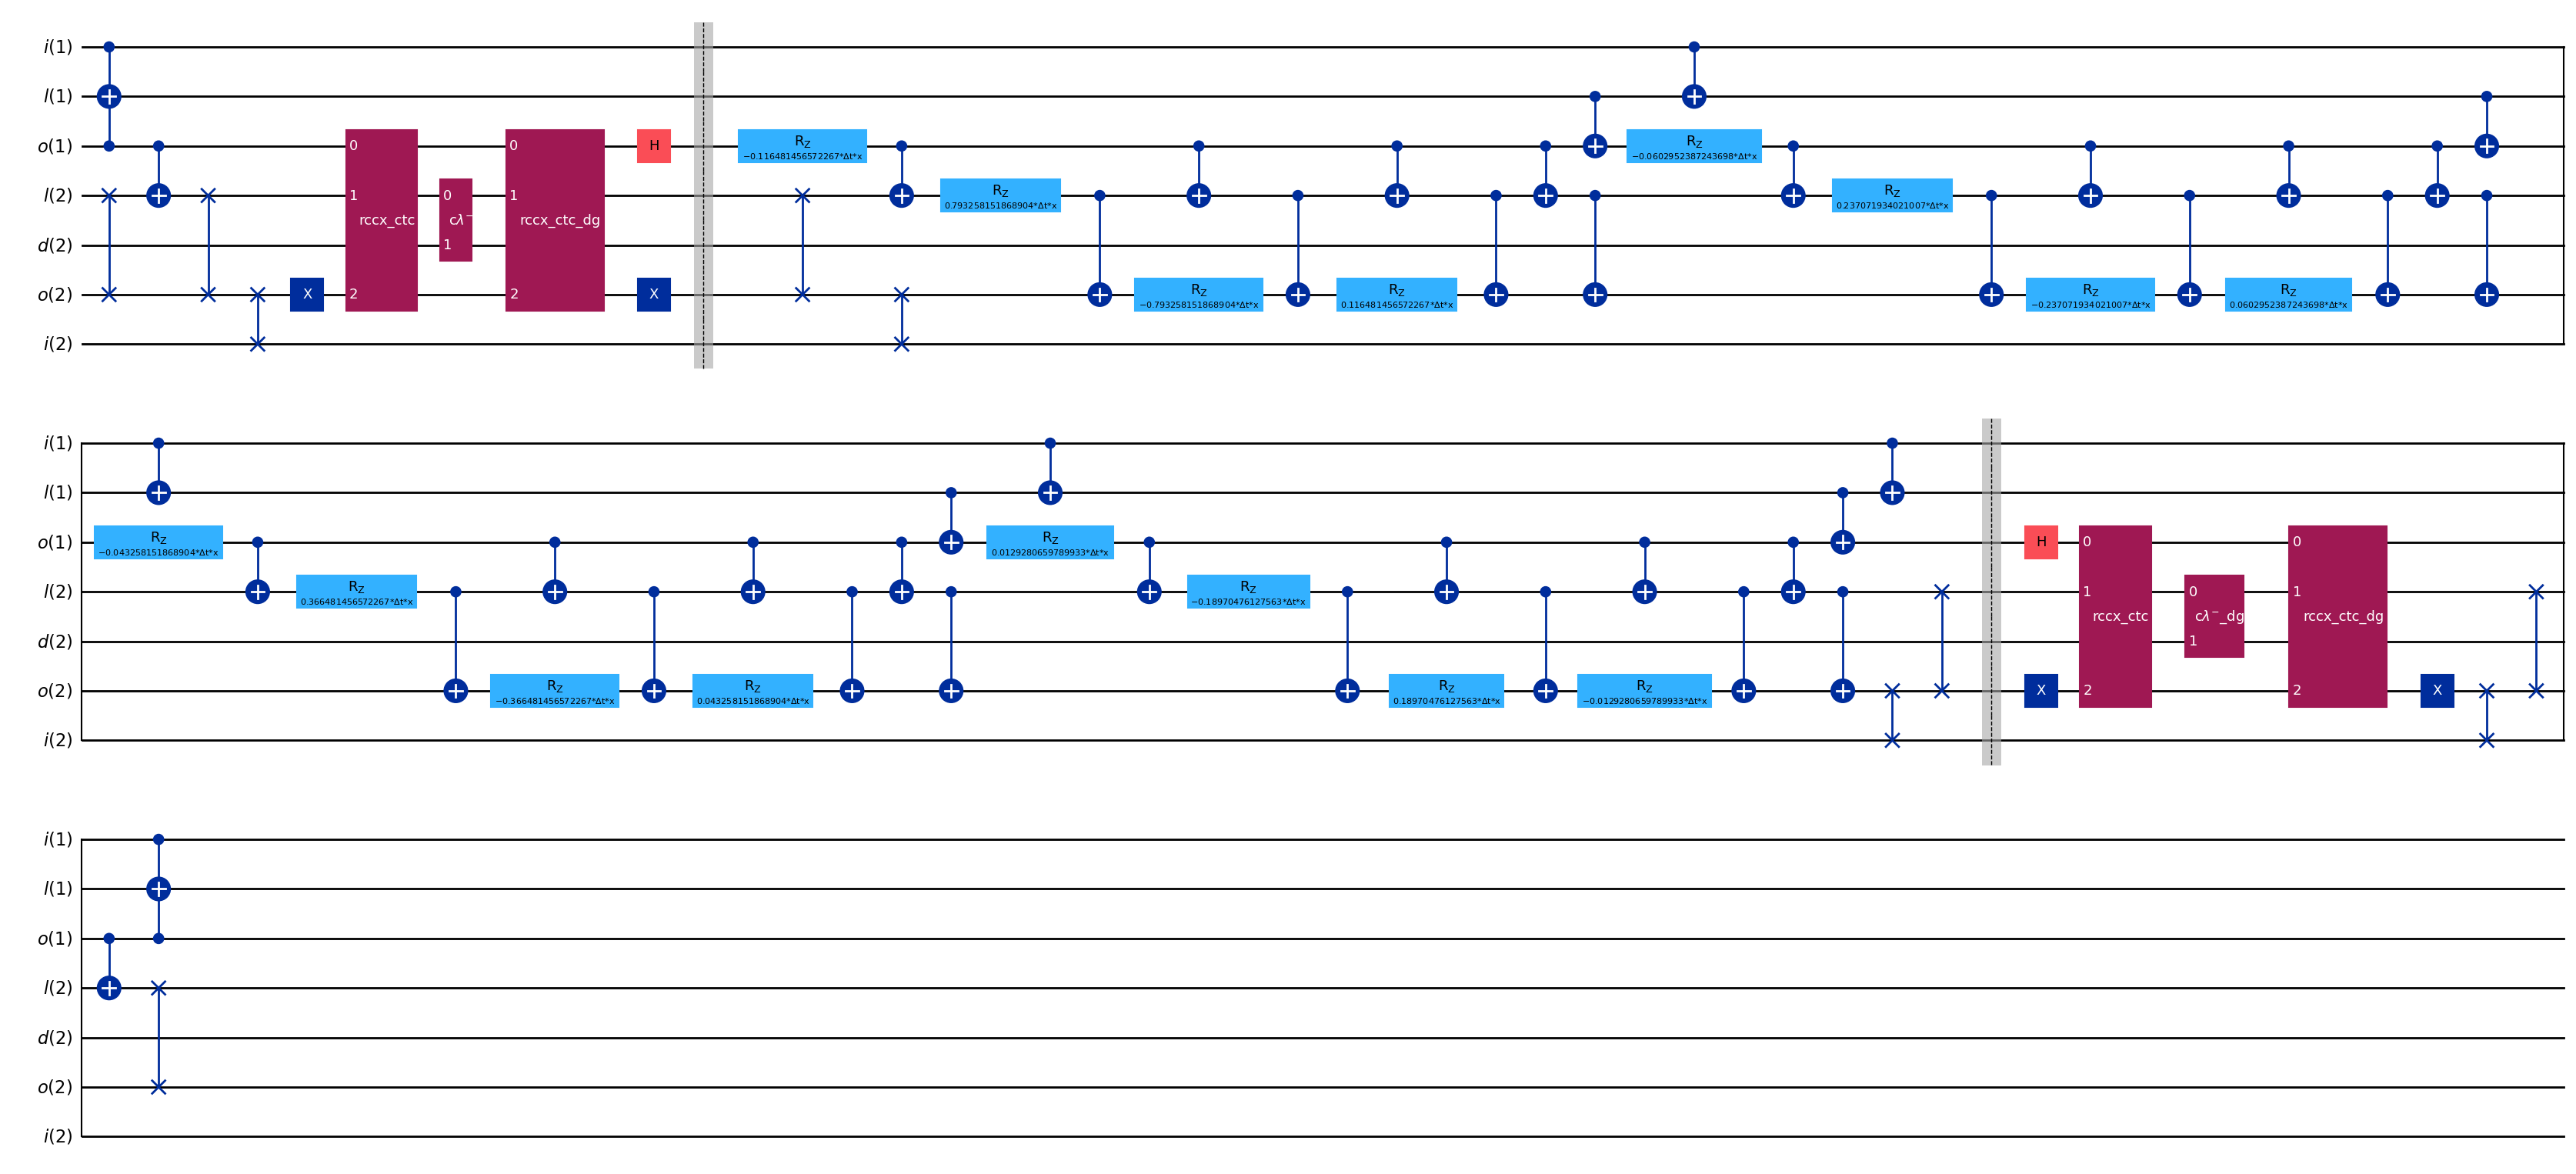

In [20]:
circuit, init_p, _ = hopping_term(2, 1, time_step, interaction_x, left_flux=(0, 1))
draw_circuit(circuit, init_p, reorder=False, fold=50)

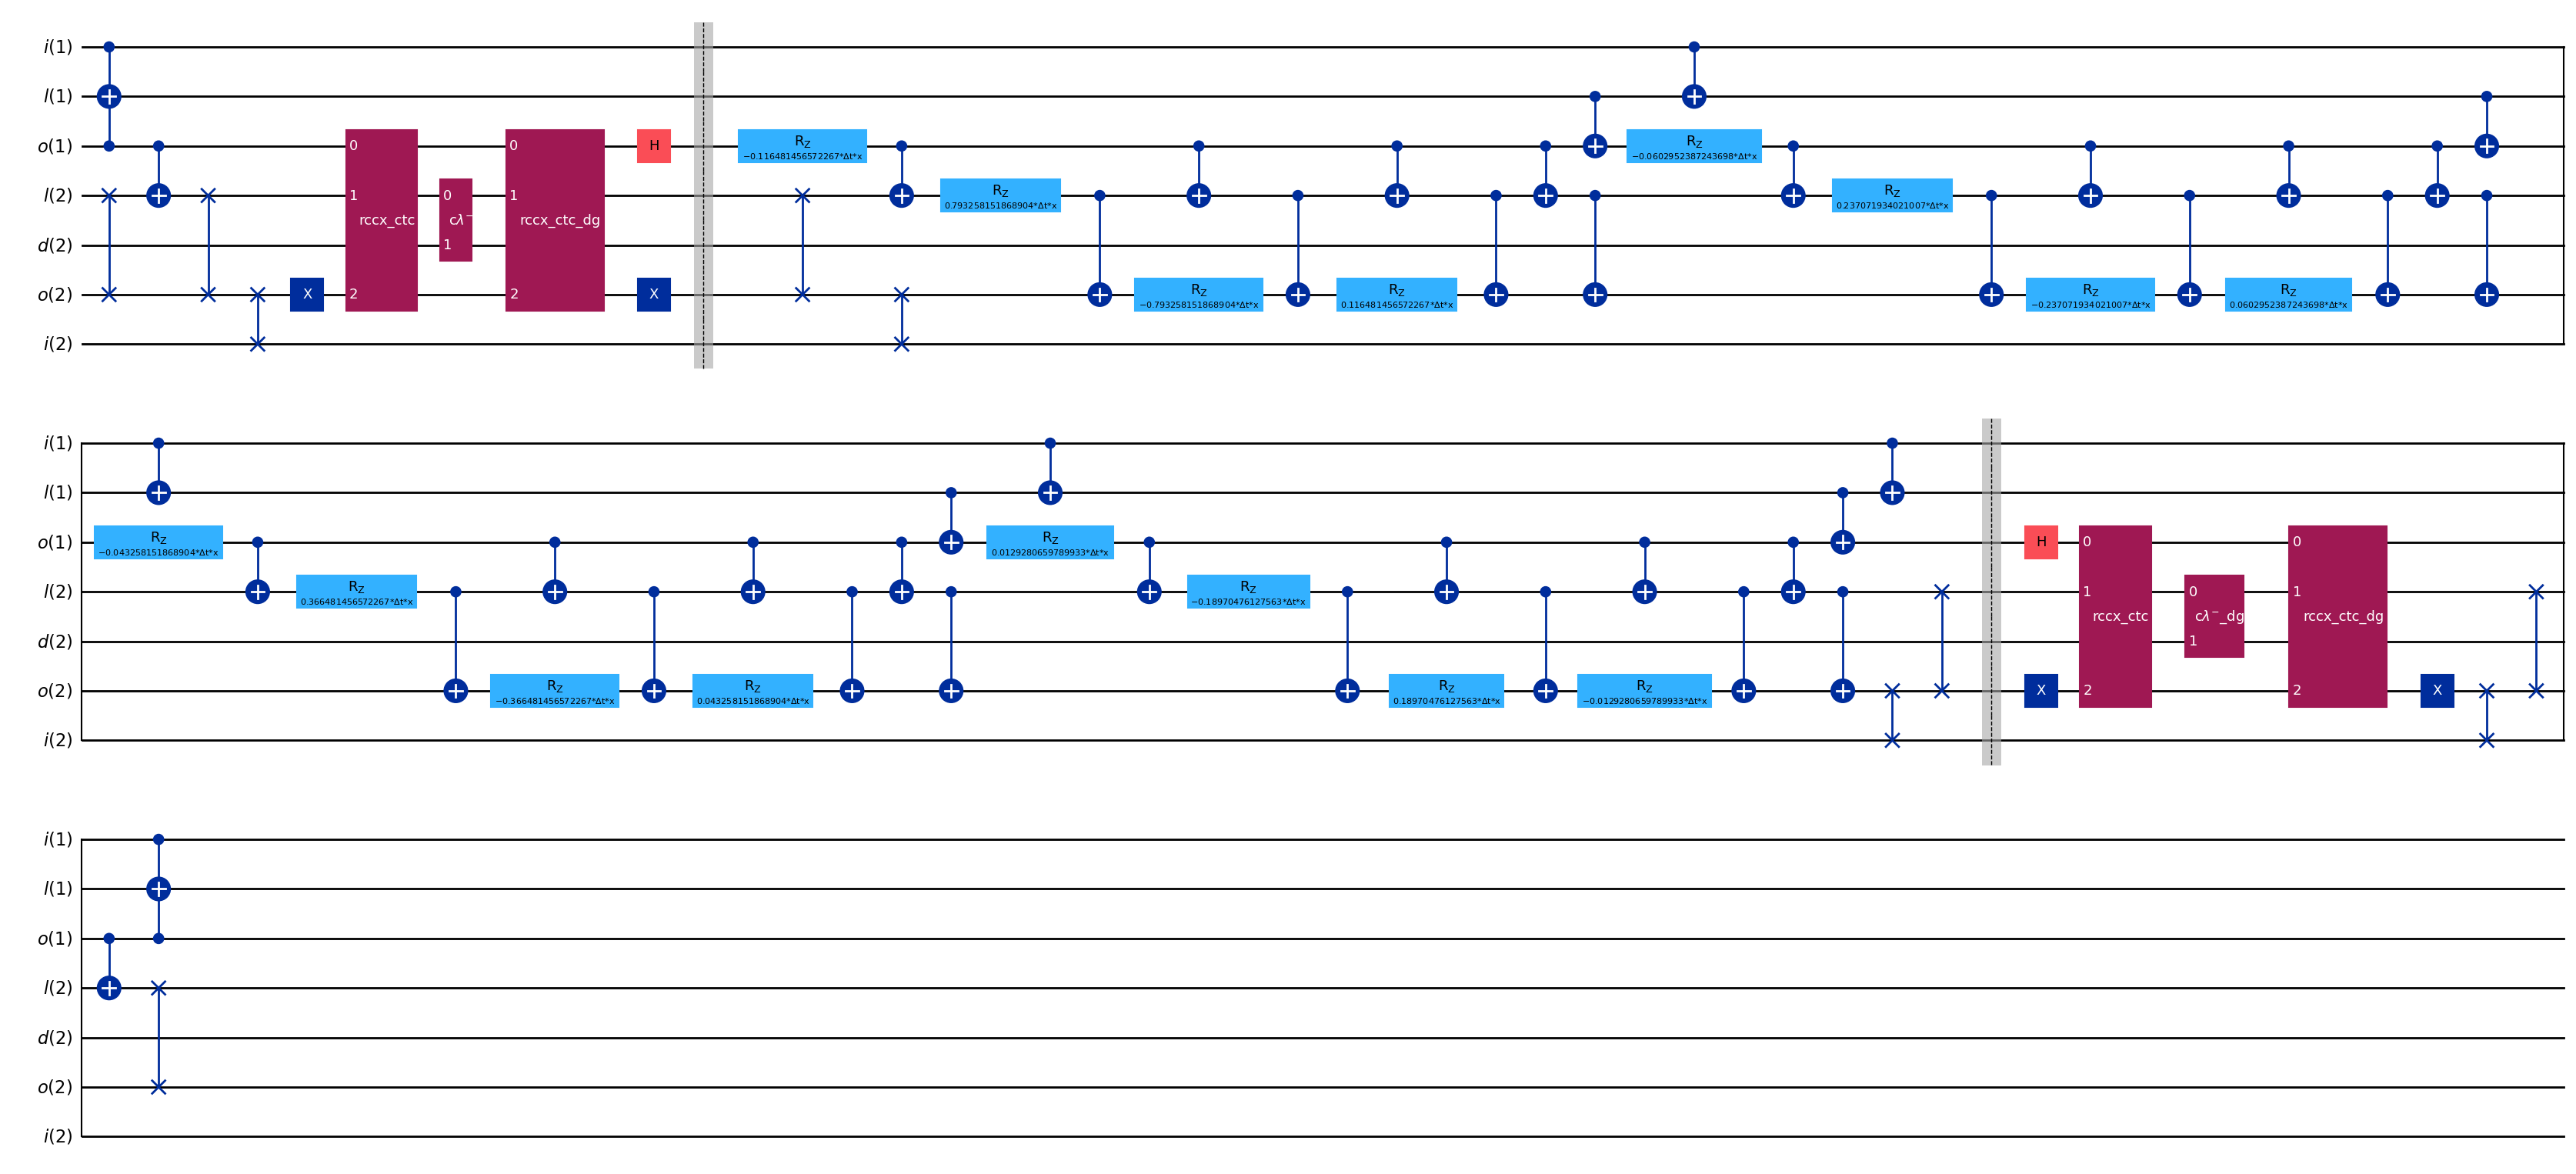

In [21]:
circuit, init_p, _ = hopping_term(2, 1, time_step, interaction_x, left_flux=(0, 1))
draw_circuit(circuit, init_p, reorder=False, fold=50)

In [22]:
assigned = circuit.decompose(custom_gates).assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('l', 2), ('d', 2), ('o', 2), ('i', 2), ('l', 1), ('o', 1), ('i', 1)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi2_mat.reshape(4, 3, 12, 4, 3, 12)[:, :2, :, :, :2, :].reshape(96, 96) * x * dt
subspace = np.sum(physical_states(left_flux=(0, 1), num_sites=2, as_multi=True) * np.cumprod([1, 3, 2, 2, 2, 2])[None, ::-1], axis=1)
validate_circuit(ordered, hmat, qutrits=(1,), ancillae=(0,), subspace=subspace)

True

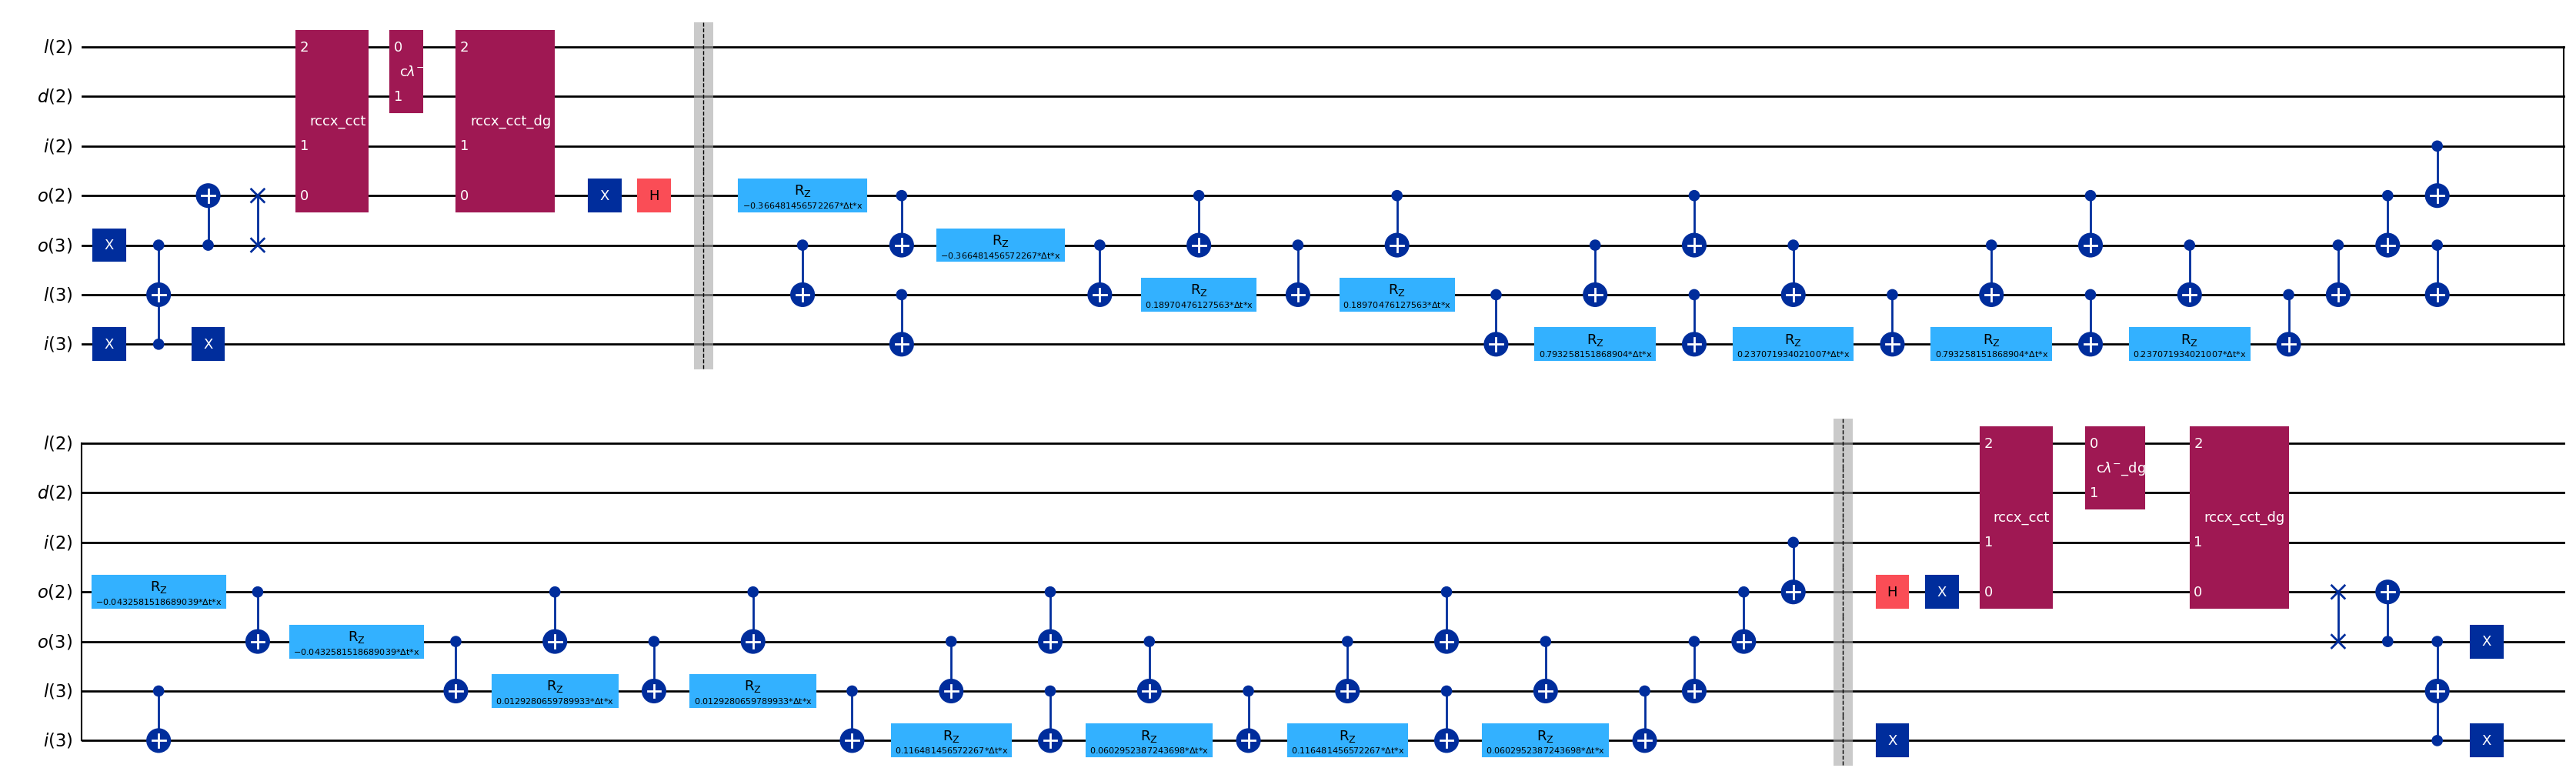

In [23]:
circuit, init_p, _ = hopping_term(2, 2, time_step, interaction_x, right_flux=(0, 1))
draw_circuit(circuit, init_p, reorder=False, fold=50)

In [24]:
assigned = circuit.decompose(custom_gates).assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('l', 3), ('o', 3), ('i', 3), ('l', 2), ('d', 2), ('o', 2), ('i', 2)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi2_mat.reshape(12, 4, 3, 12, 4, 3)[:, :, :2, :, :, :2].reshape(96, 96) * x * dt
subspace = np.sum(physical_states(right_flux=(0, 1), num_sites=2, as_multi=True) * np.cumprod([1, 2, 2, 2, 3, 2])[None, ::-1], axis=1)
validate_circuit(ordered, hmat, qutrits=(4,), ancillae=(3,), subspace=subspace)

True

## Full circuit

In [25]:
from lsh_qudit.hamiltonian import hopping_term_config
configs = [hopping_term_config(ttype, site, left_flux=lflux, right_flux=rflux)
           for ttype, site, lflux, rflux in [(1, 0, 0, None), (1, 1, (0, 1), None), (1, 2, None, (0, 1)), (2, 0, 0, None), (2, 1, (0, 1), None), (2, 2, None, (0, 1))]]

config_itr = iter(configs)
for ttype in [1, 2]:
    for site in range(3):
        config = next(config_itr)
        print(ttype, site, config.boson_ops['p'], config.boson_ops['q'])

1 0 ('id', 'id') ('X', 'zero')
1 1 ('X', 'zero') ('lambda', 'id')
1 2 ('lambda', 'id') ('X', 'zero')
2 0 ('X', 'zero') ('id', 'id')
2 1 ('lambda', 'id') ('X', 'zero')
2 2 ('X', 'zero') ('lambda', 'id')


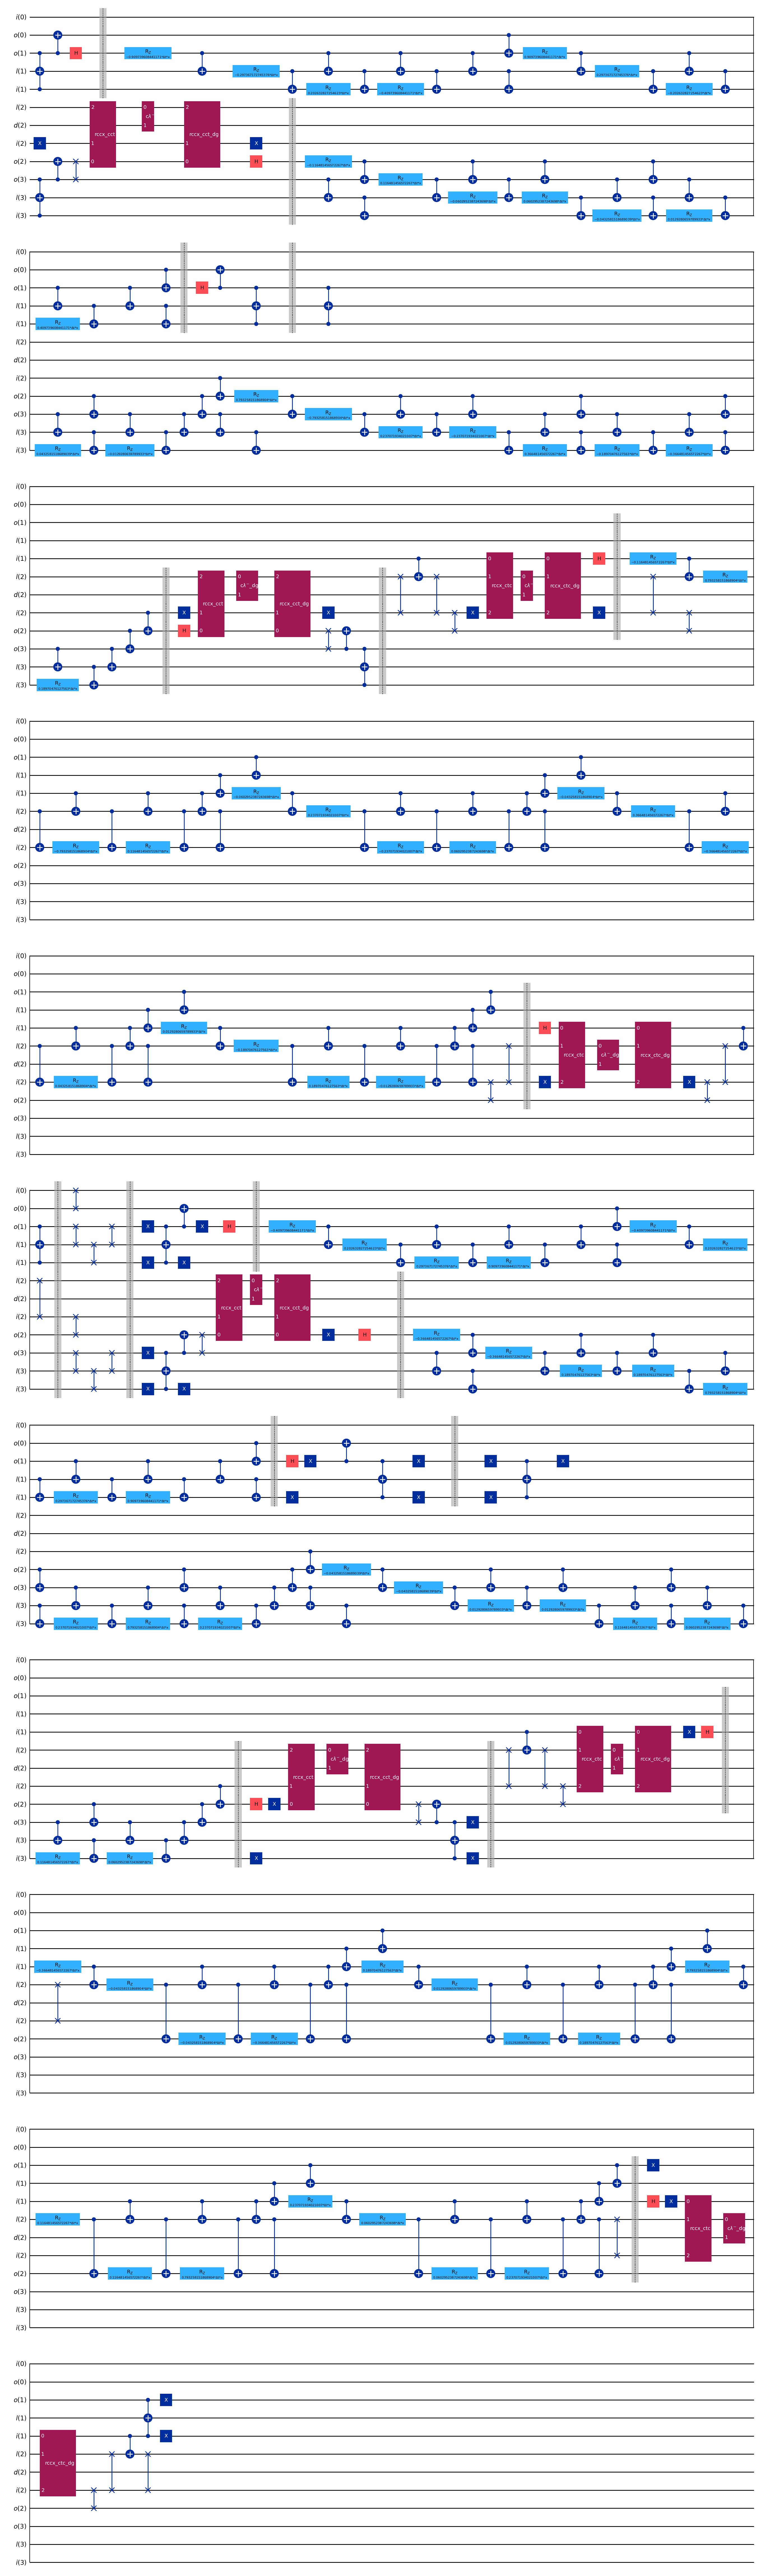

In [26]:
qp = QubitPlacement(
    [('o', 0), ('i', 0)]
    + [('i', 1), ('l', 1), ('o', 1)]
    + [('l', 2), ('d', 2), ('o', 2), ('i', 2)]
    + [('i', 3), ('l', 3), ('o', 3)]
)
full_circuit = QuantumCircuit(qp.num_qubits)

def swap(qp, l1, l2):
    full_circuit.swap(qp[l1], qp[l2])
    return qp.swap(l1, l2)

circ, init_p, _ = hopping_term(1, 0, time_step, interaction_x, left_flux=0)
full_circuit.compose(circ, qubits=[qp[label] for label in init_p.qubit_labels], inplace=True)
full_circuit.barrier([qp[label] for label in init_p.qubit_labels])

circ, init_p, _ = hopping_term(1, 2, time_step, interaction_x, right_flux=(0, 1))
full_circuit.compose(circ, qubits=[qp[label] for label in init_p.qubit_labels], inplace=True)
full_circuit.barrier([qp[label] for label in init_p.qubit_labels])

circ, init_p, _ = hopping_term(2, 1, time_step, interaction_x, left_flux=(0, 1))
full_circuit.compose(circ, qubits=[qp[label] for label in init_p.qubit_labels], inplace=True)
full_circuit.barrier()

qp = swap(qp, ('o', 0), ('i', 0))
qp = swap(qp, ('i', 1), ('l', 1))
qp = swap(qp, ('i', 1), ('o', 1))
qp = swap(qp, ('l', 1), ('o', 1))
qp = swap(qp, ('o', 2), ('i', 2))
qp = swap(qp, ('i', 3), ('l', 3))
qp = swap(qp, ('i', 3), ('o', 3))
qp = swap(qp, ('l', 3), ('o', 3))
full_circuit.barrier()

circ, init_p, _ = hopping_term(2, 0, time_step, interaction_x, left_flux=0)
full_circuit.compose(circ, qubits=[qp[label] for label in init_p.qubit_labels], inplace=True)
full_circuit.barrier([qp[label] for label in init_p.qubit_labels])

circ, init_p, _ = hopping_term(2, 2, time_step, interaction_x, right_flux=(0, 1))
full_circuit.compose(circ, qubits=[qp[label] for label in init_p.qubit_labels], inplace=True)
full_circuit.barrier([qp[label] for label in init_p.qubit_labels])

circ, init_p, _ = hopping_term(1, 1, time_step, interaction_x, left_flux=(0, 1))
full_circuit.compose(circ, qubits=[qp[label] for label in init_p.qubit_labels], inplace=True)

draw_circuit(full_circuit, qp, reorder=False, fold=40)

In [32]:
full_circuit.decompose(custom_gates).count_ops()

OrderedDict([('cx', 282),
             ('rz', 88),
             ('ry', 64),
             ('swap', 30),
             ('x', 20),
             ('ccx', 12),
             ('h', 12),
             ('qubit_qutrit_crx_minuspi', 8),
             ('xminus', 8),
             ('xplus', 8),
             ('qubit_qutrit_crx_pluspi', 8)])

In [35]:
backend.configuration().basis_gates

['cz', 'id', 'rz', 'sx', 'x']

In [36]:
# Initial mapping of occupation numbers to physical qubits (i and o get swapped)
#                d2
# o0-i0-i1-l1-o1-l2-o2-i2-i3-l3-o3
layout = {
    ('o', 0): 2,
    ('i', 0): 3,
    ('i', 1): 4,
    ('l', 1): 5,
    ('o', 1): 6,
    ('l', 2): 7,
    ('d', 2): 17,
    ('o', 2): 8,
    ('i', 2): 9,
    ('i', 3): 10,
    ('l', 3): 11,
    ('o', 3): 12
}

qutrit_gates = ['qubit_qutrit_crx_minuspi', 'qubit_qutrit_crx_pluspi', 'xminus', 'xplus']
pm = generate_preset_pass_manager(optimization_level=3, backend=backend,
                                  initial_layout=[layout[label] for label in qp.qubit_labels],
                                  basis_gates=backend.configuration().basis_gates + qutrit_gates)

In [37]:
pm.run(full_circuit).count_ops()

OrderedDict([('sx', 967),
             ('rz', 841),
             ('cz', 512),
             ('x', 10),
             ('qubit_qutrit_crx_minuspi', 8),
             ('xminus', 8),
             ('xplus', 8),
             ('qubit_qutrit_crx_pluspi', 8)])

In [38]:
dir(pm)

['__abstractmethods__',
 '__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_expanded_stages',
 '_finalize_layouts',
 '_flatten_tasks',
 '_generate_expanded_stages',
 '_passmanager_backend',
 '_passmanager_frontend',
 '_stages',
 '_tasks',
 '_update_passmanager',
 '_validate_init_kwargs',
 '_validate_stages',
 'append',
 'draw',
 'expanded_stages',
 'init',
 'invalid_stage_regex',
 'layout',
 'max_iteration',
 'optimization',
 'post_init',
 'post_layout',
 'post_optimization',
 'post_routing',
 'post_scheduling',
 'post_translation',
 'pre_init',
 'pre_layout',
 'pre_optimization',
 'pre_r

In [41]:
dir(pm.init)

['__abstractmethods__',
 '__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_finalize_layouts',
 '_flatten_tasks',
 '_passmanager_backend',
 '_passmanager_frontend',
 '_tasks',
 'append',
 'draw',
 'max_iteration',
 'property_set',
 'remove',
 'replace',
 'run',
 'to_flow_controller']

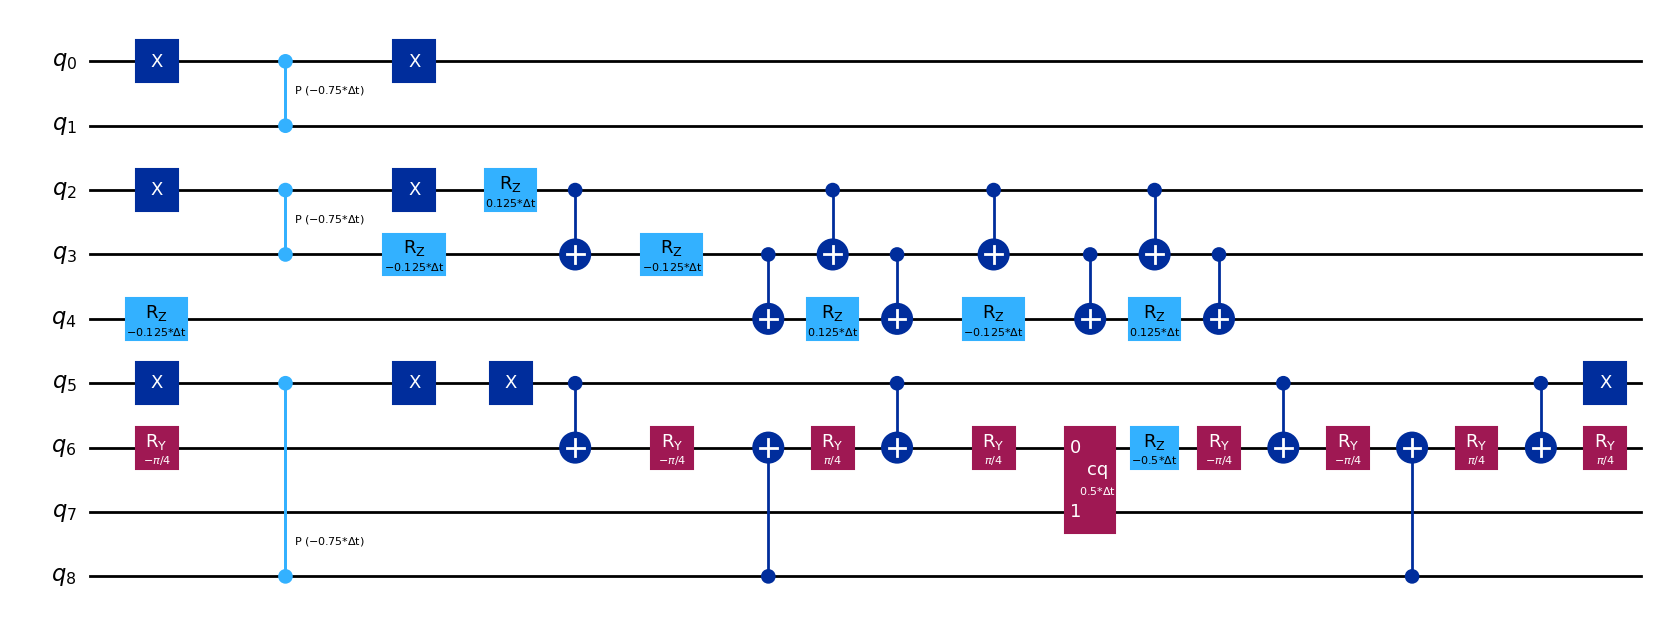

In [66]:
from qiskit.transpiler import PassManager
testpm = PassManager([tlist[0] for tlist in pm.init._tasks[:2]])
testpm.run(electric_3_circuit).draw('mpl')

In [42]:
pm.init._tasks

[[<qiskit.transpiler.passes.synthesis.unitary_synthesis.UnitarySynthesis at 0x7da8e3be1510>],

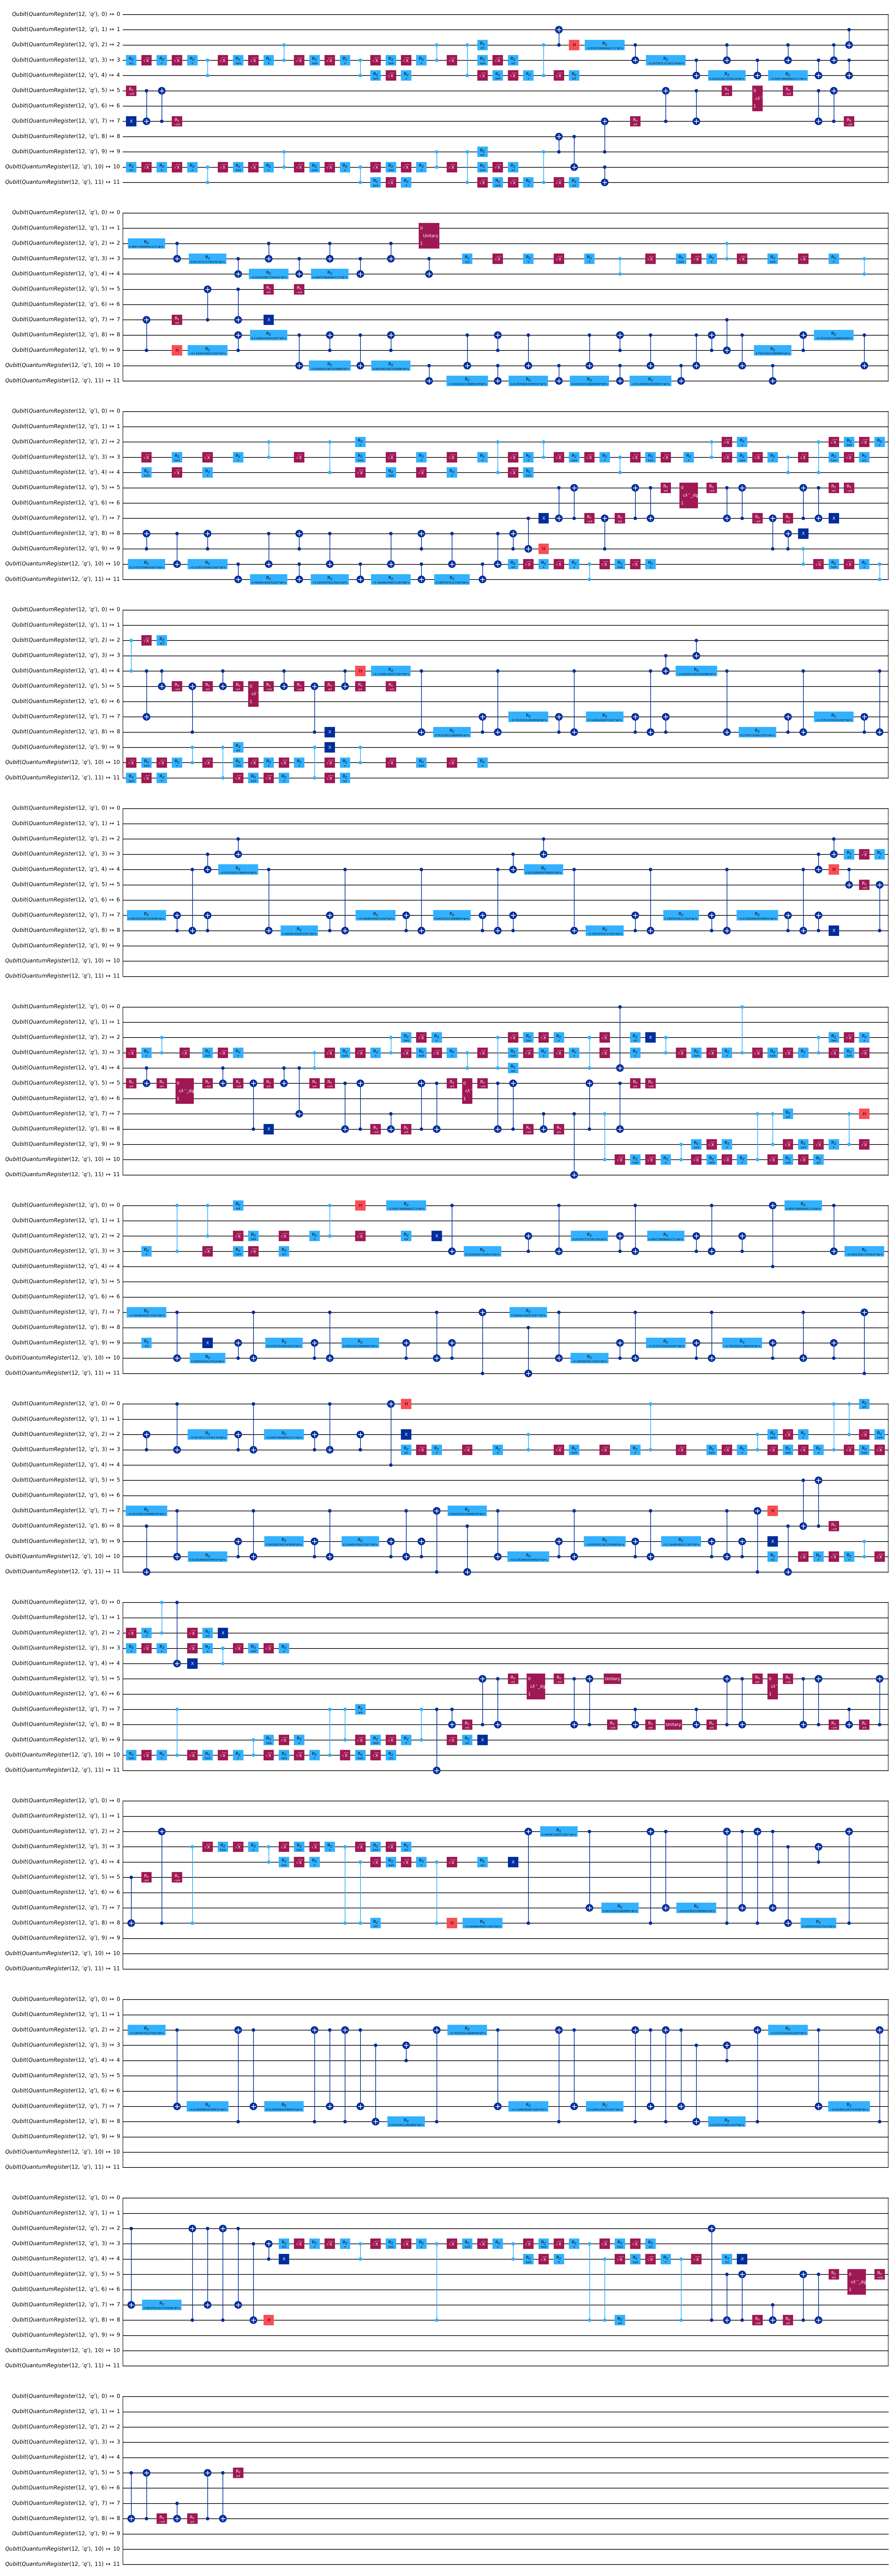

In [43]:
pm.init.run(full_circuit).draw('mpl', fold=50)

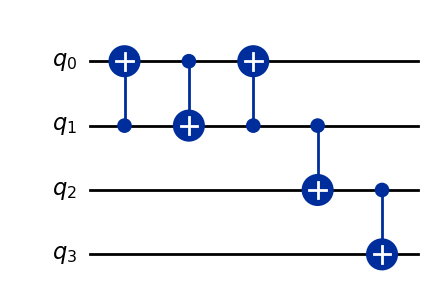

In [48]:
c = QuantumCircuit(4)
# c.ccx(1, 3, 2)
# c.cx(1, 0)
#c.swap(0, 1)
c.cx(1, 0)
c.cx(0, 1)
c.cx(1, 0)
c.cx(1, 2)
c.cx(2, 3)
pm.init.run(c).draw('mpl')

In [ ]:


dag = circuit_to_dag(full_circuit)

In [50]:
node = next(node for node in dag.topological_op_nodes() if node.op.name == 'rccx_cct_dg')

In [54]:
list(dag.op_successors(node))

[DAGOpNode(op=Instruction(name='rccx_cct', num_qubits=3, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(12, 'q'), 8), Qubit(QuantumRegister(12, 'q'), 7), Qubit(QuantumRegister(12, 'q'), 5)), cargs=()),
 DAGOpNode(op=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(12, 'q'), 8),), cargs=()),
 DAGOpNode(op=Instruction(name='x', num_qubits=1, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(12, 'q'), 7),), cargs=())]

In [55]:
len((suc := list(dag.op_successors(node)))) > 1 or suc[0].op.name != 'rccx_cct'

True

In [61]:
node = next(node for node in dag.topological_op_nodes() if node.op.name == r'c$\lambda^{-}$_dg')

In [62]:
node

DAGOpNode(op=Instruction(name='c$\lambda^{-}$_dg', num_qubits=2, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(12, 'q'), 5), Qubit(QuantumRegister(12, 'q'), 6)), cargs=())

In [82]:
dag = circuit_to_dag(hopping_term(2, 2, time_step, interaction_x, right_flux=(0, 1))[0])

In [83]:
for node in dag.topological_op_nodes():
    if node.op.name not in custom_gates:
        continue
    subdag = circuit_to_dag(node.op.definition)
    mapping = {qubit: qarg for qubit, qarg in zip(subdag.qubits, node.qargs)}
    dag.substitute_node_with_dag(node, subdag, wires=mapping)


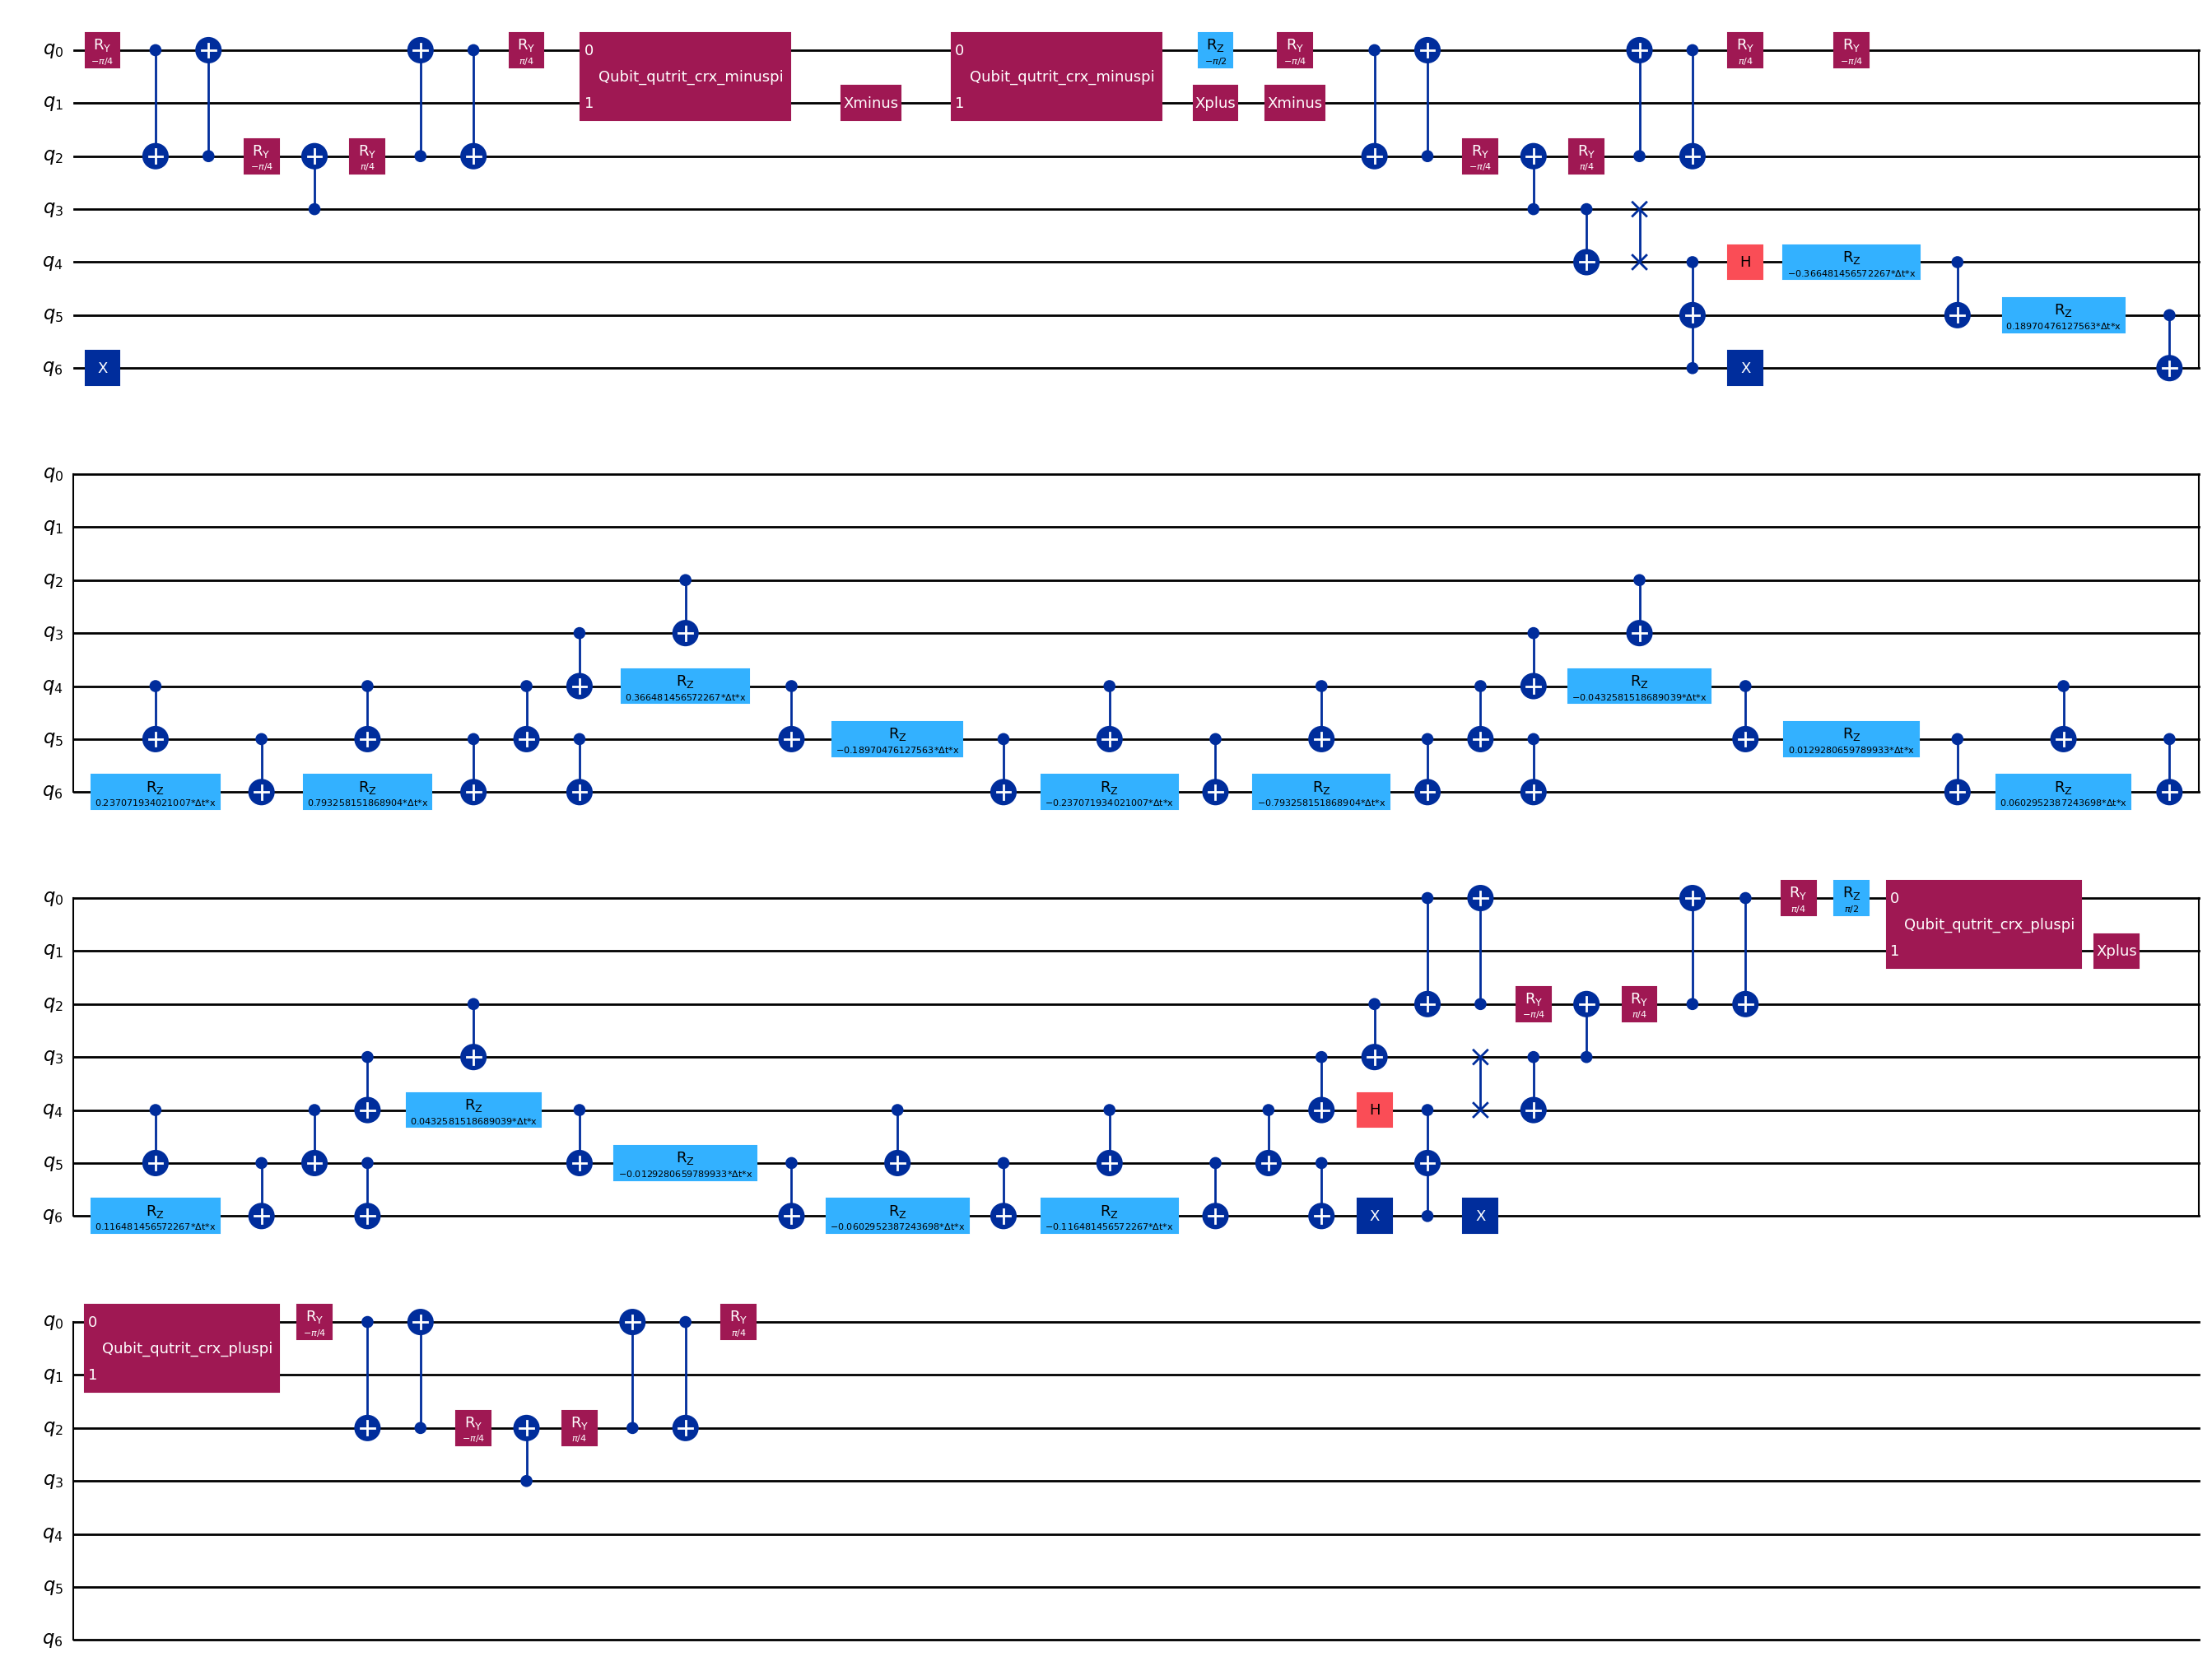

In [84]:
from qiskit.converters import dag_to_circuit

dag_to_circuit(dag).draw('mpl', fold=40)

In [78]:
node = next(node for node in dag.topological_op_nodes() if node.op.name in custom_gates)

In [79]:
node.qargs

(Qubit(QuantumRegister(7, 'q'), 3),
 Qubit(QuantumRegister(7, 'q'), 2),
 Qubit(QuantumRegister(7, 'q'), 0))

In [ ]:
subdag = circuit_to_dag(node.op.definition)

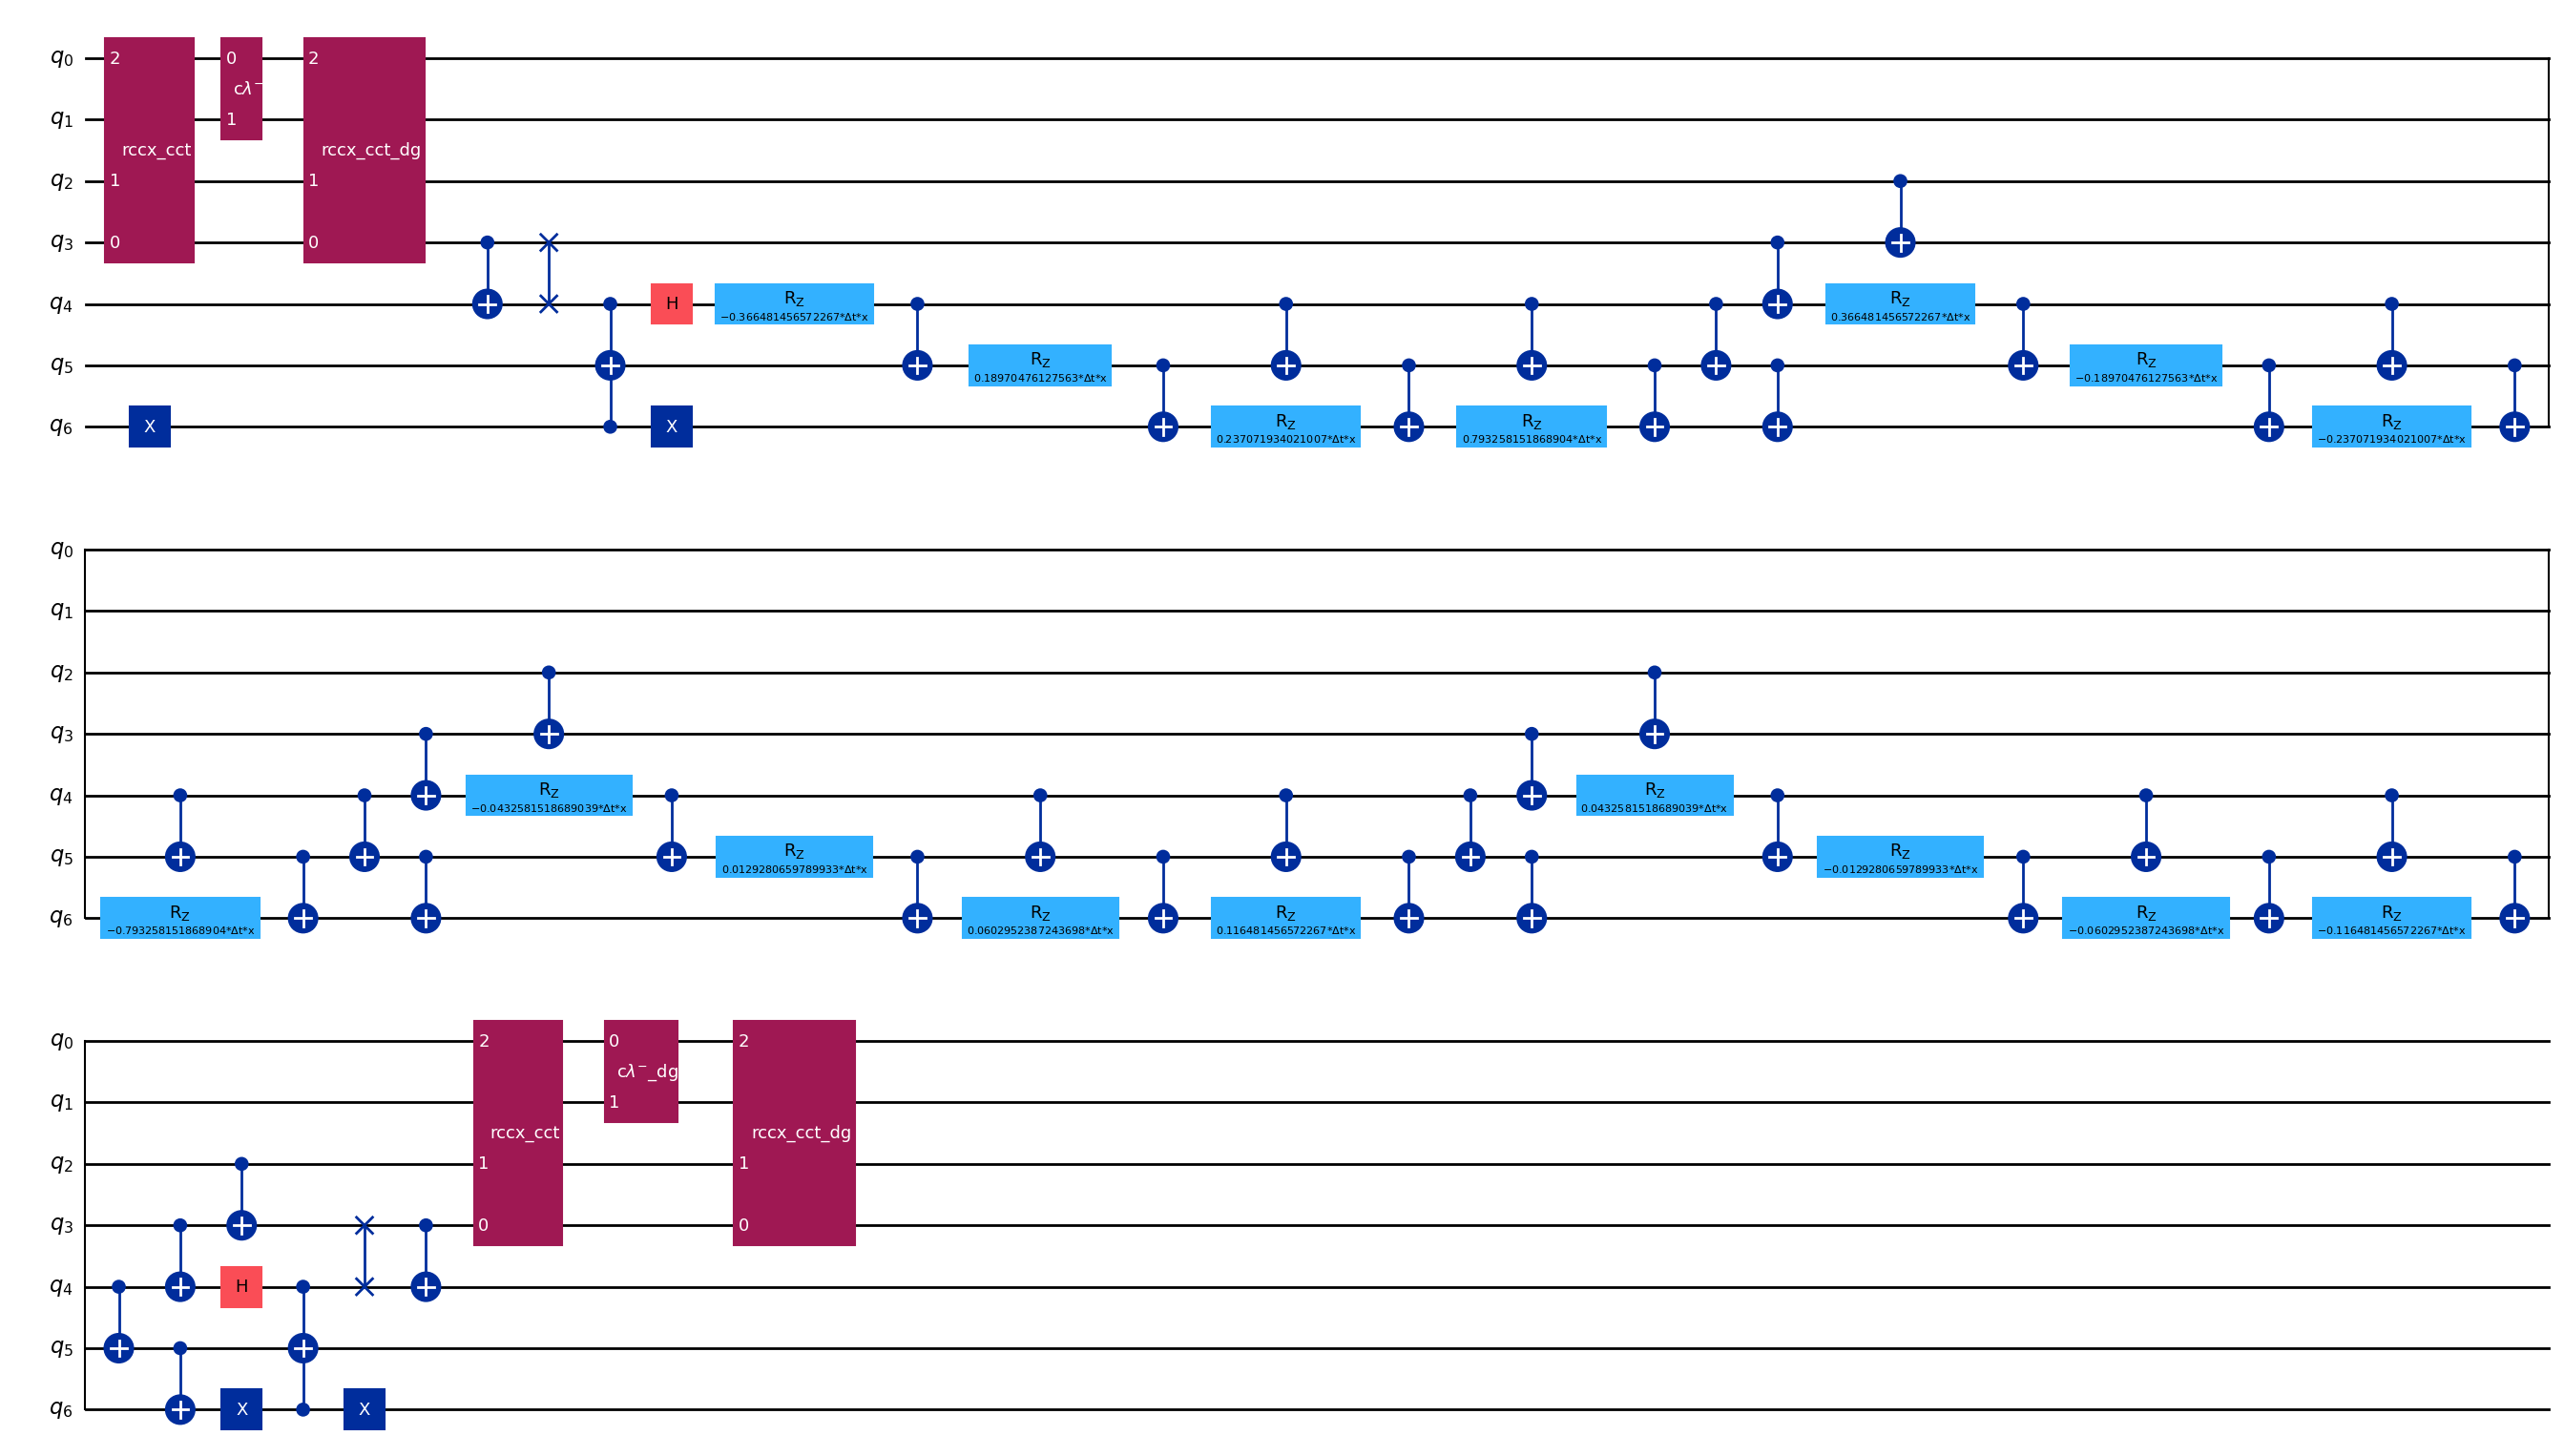

In [80]:
hopping_term(2, 2, time_step, interaction_x, right_flux=(0, 1))[0].draw('mpl', fold=40)